### TYK2 Multi-Assay Integration

For the TYK2 variant pool, we now have data across many variants from two independent experimental methods: IFN-alpha DMS and VAMP-seq. Due to VAMP-seq dropout, we have three chunks (3, 10, and 14) with meaningful overlap between the two experiments. We also have multiple IFN-alpha concentrations in the DMS only, and multiple activity bins in VAMP-seq only.

1. [Primary LoF Signal Comparison](#part1)
2. [Contrast and Pairwise Correlations](#part2)
3. [Dimensional Projections](#part3)
4. [Biochemical Aggregation](#part4)
5. [Comparison with Midpoints](#part5)

In [2]:
library(ggpubr)
library(patchwork)
library(knitr)
library(ggside)
#library(Rtsne)
library(ggbeeswarm)
library(scico)
#library(ggcorrplot)
library(scales)
library(tidyverse)

scale_fill_scico_mid <- function(..., mid = 0, alpha = NULL, begin = 0, end = 1, direction = 1, reverse = TRUE ,palette = "broc") {
  if (!requireNamespace("ggplot2", quietly = TRUE)) {
        stop("ggplot2 is required for this functionality", call. = FALSE)
  }
  force(mid)
  ggplot2::continuous_scale(
    aesthetics = "fill", 
    scale_name = "gradient2",
    palette = scales::gradient_n_pal(
      colours = scico(256, alpha, begin, end, direction, palette), 
      values = NULL, space = "Lab"),
    guide="colourbar",
    rescaler = function(x, to = c(0, 1), from = range(x, na.rm = TRUE)) {
      scales::rescale_mid(x, to, from, mid)
    },
    ...
  )
}

#### Primary LoF Signal Comparison <a name="part1"></a>

We know from each assay individually that the clearest observed variant effect patterns are the strong LoF under either high IFN-alpha treatment (IFNalpha100) in DMS, and also that the slopes in conditions C and D were the strongest in VAMP-seq. We can extract just these summary statistics for the overlapping chunks, and plot them. Both sets of plots below are identical except the scale is zoomed in on the lower set:

In [9]:
dms_full <- read_tsv("../sumstats/TYK2/run3/tyk2-assay3-unnormalized.tsv") %>%
    mutate(condition = factor(condition, levels = c("IFNbeta100", "None0", "IFNalpha1",
                                                    "IFNalpha10", "IFNalpha100", "IFNalphaWithDrug100")))
vamp_full <- read_tsv("../sumstats/TYK2-VAMP/run1/tyk2-vampseq-bin.sumstats.tsv")

dms <- read_tsv("../sumstats/TYK2/run3/tyk2-assay3.tsv") %>%
    filter(chunk %in% c("3", "10", "14")) %>%
    filter(condition == "IFNalpha100 - None0")
vamp <- read_tsv("../sumstats/TYK2-VAMP/run1/tyk2-vampseq-slope.sumstats.tsv") %>%
    mutate(chunk = as.character(chunk)) %>%
    filter(chunk %in% c("3", "10", "14"),
           source %in% c("3-C", "10-C", "14-C"))

combined <- inner_join(dms, vamp, by = c("pos", "chunk", "aa")) %>%
    mutate(group = case_when(p.adj.x < 0.01 & p.adj.y < 0.01 ~ "Both",
                             p.adj.x < 0.01 & p.adj.y > 0.01 ~ "DMS Only",
                             p.adj.x > 0.01 & p.adj.y < 0.01 ~ "VAMP Only",
                             TRUE ~ "Neither"))

Rows: 142338 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): clone, chunk, condition, aa, version
dbl (7): pos, estimate, std.error, statistic, p.value, dispersion, p.adj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 74384 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): condition, aa, sample
dbl (7): pos, chunk, estimate, std.error, statistic, p.value, bin

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 237230 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): clone, chunk, aa, version, condition
dbl (7): pos, estimate, std.error, dispersion, statistic, p.val

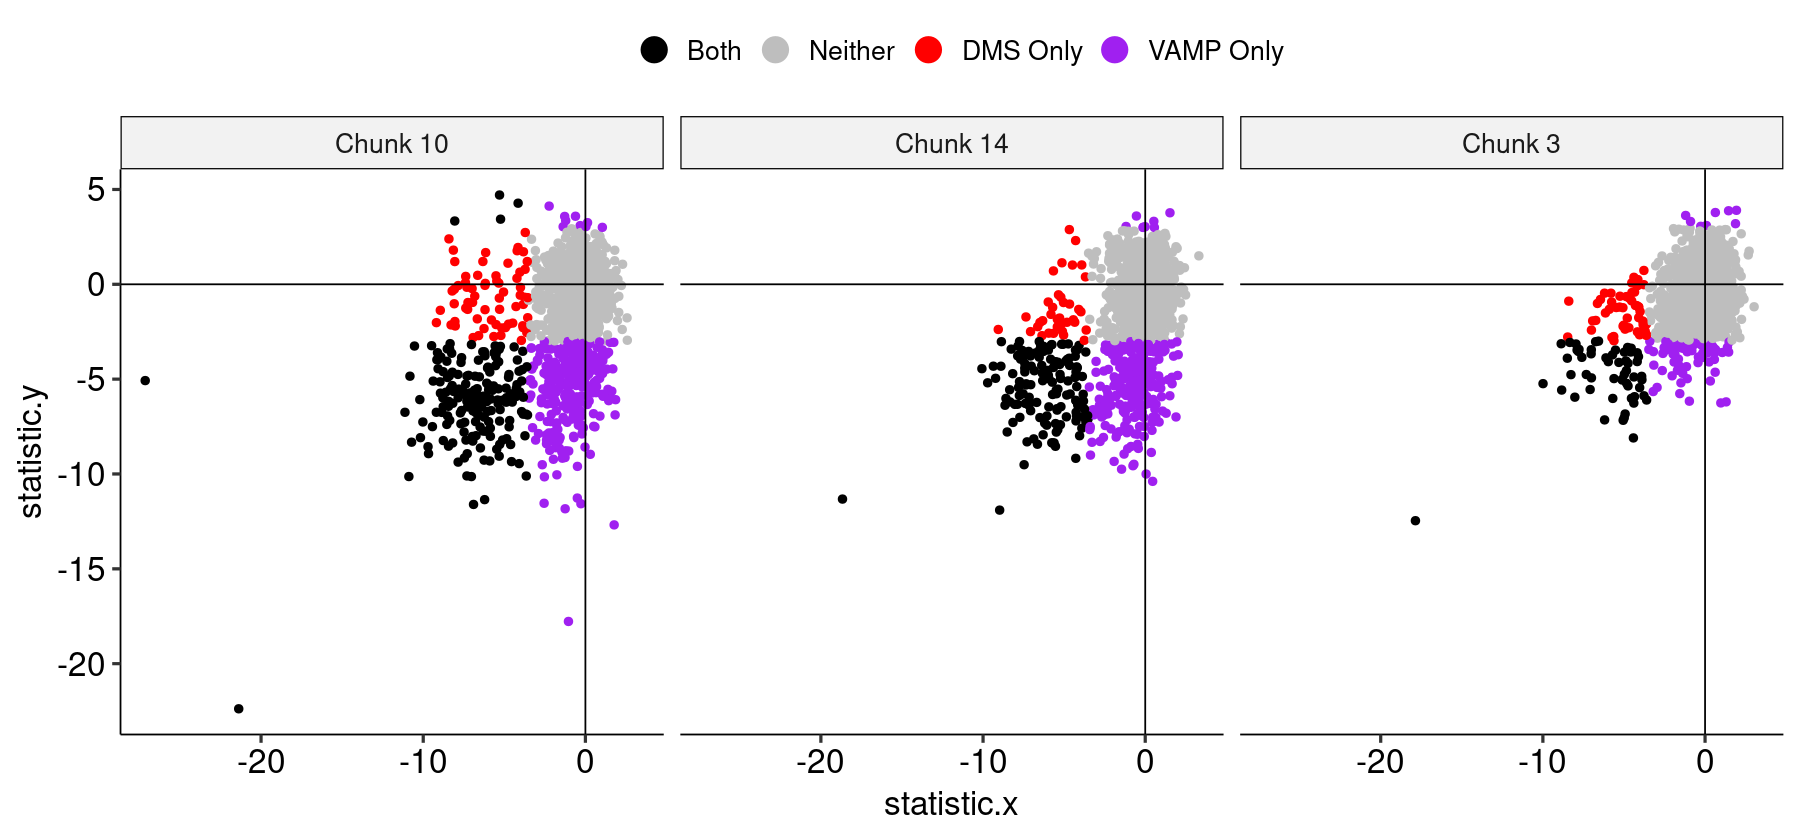

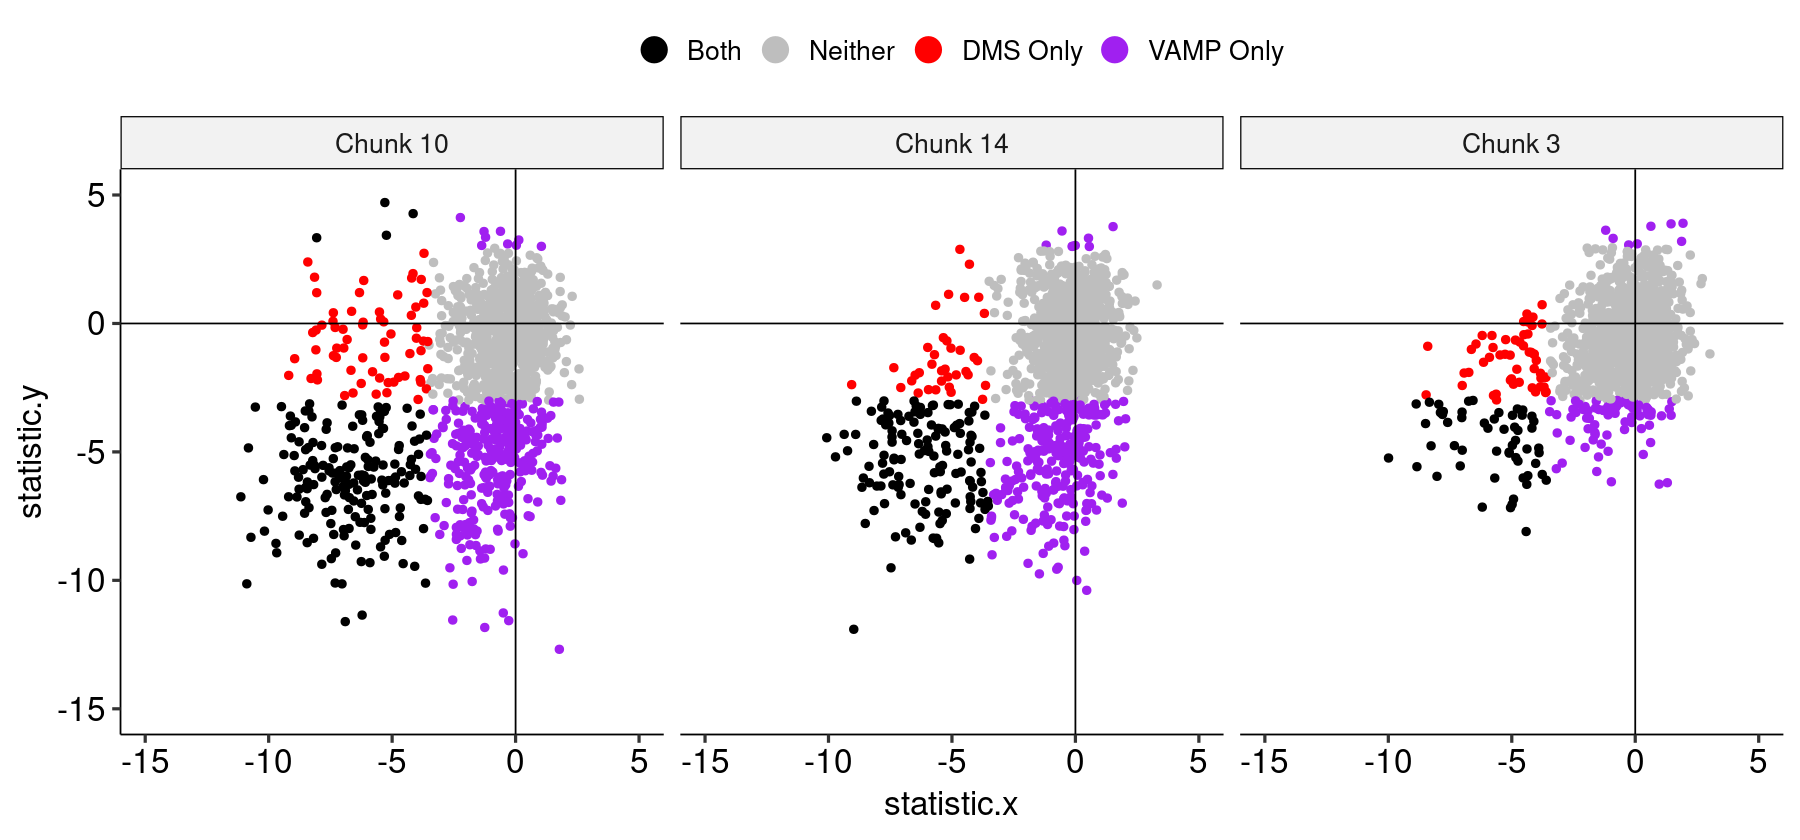

In [4]:
options(repr.plot.width = 15, repr.plot.height = 7)
combined_plot <- ggplot(combined) +
    geom_point(aes(x = statistic.x, y = statistic.y, color = group), size = 2) +
    theme_pubr(base_size = 20) +
    scale_color_manual(values = c("Both" = "black", "Neither" = "gray",
                                  "DMS Only" = "red", "VAMP Only" = "purple")) +
    facet_wrap(~paste0("Chunk ", chunk)) +
    theme(legend.title = element_blank()) + 
    guides(colour = guide_legend(override.aes = list(size=7))) +
    geom_hline(yintercept = 0) + geom_vline(xintercept = 0)

combined_plot
combined_plot + coord_cartesian(xlim = c(-15,5), ylim = c(-15,5))

We can combine the chunks and break out the stop effects as side densities, to avoid overloading the color scheme:

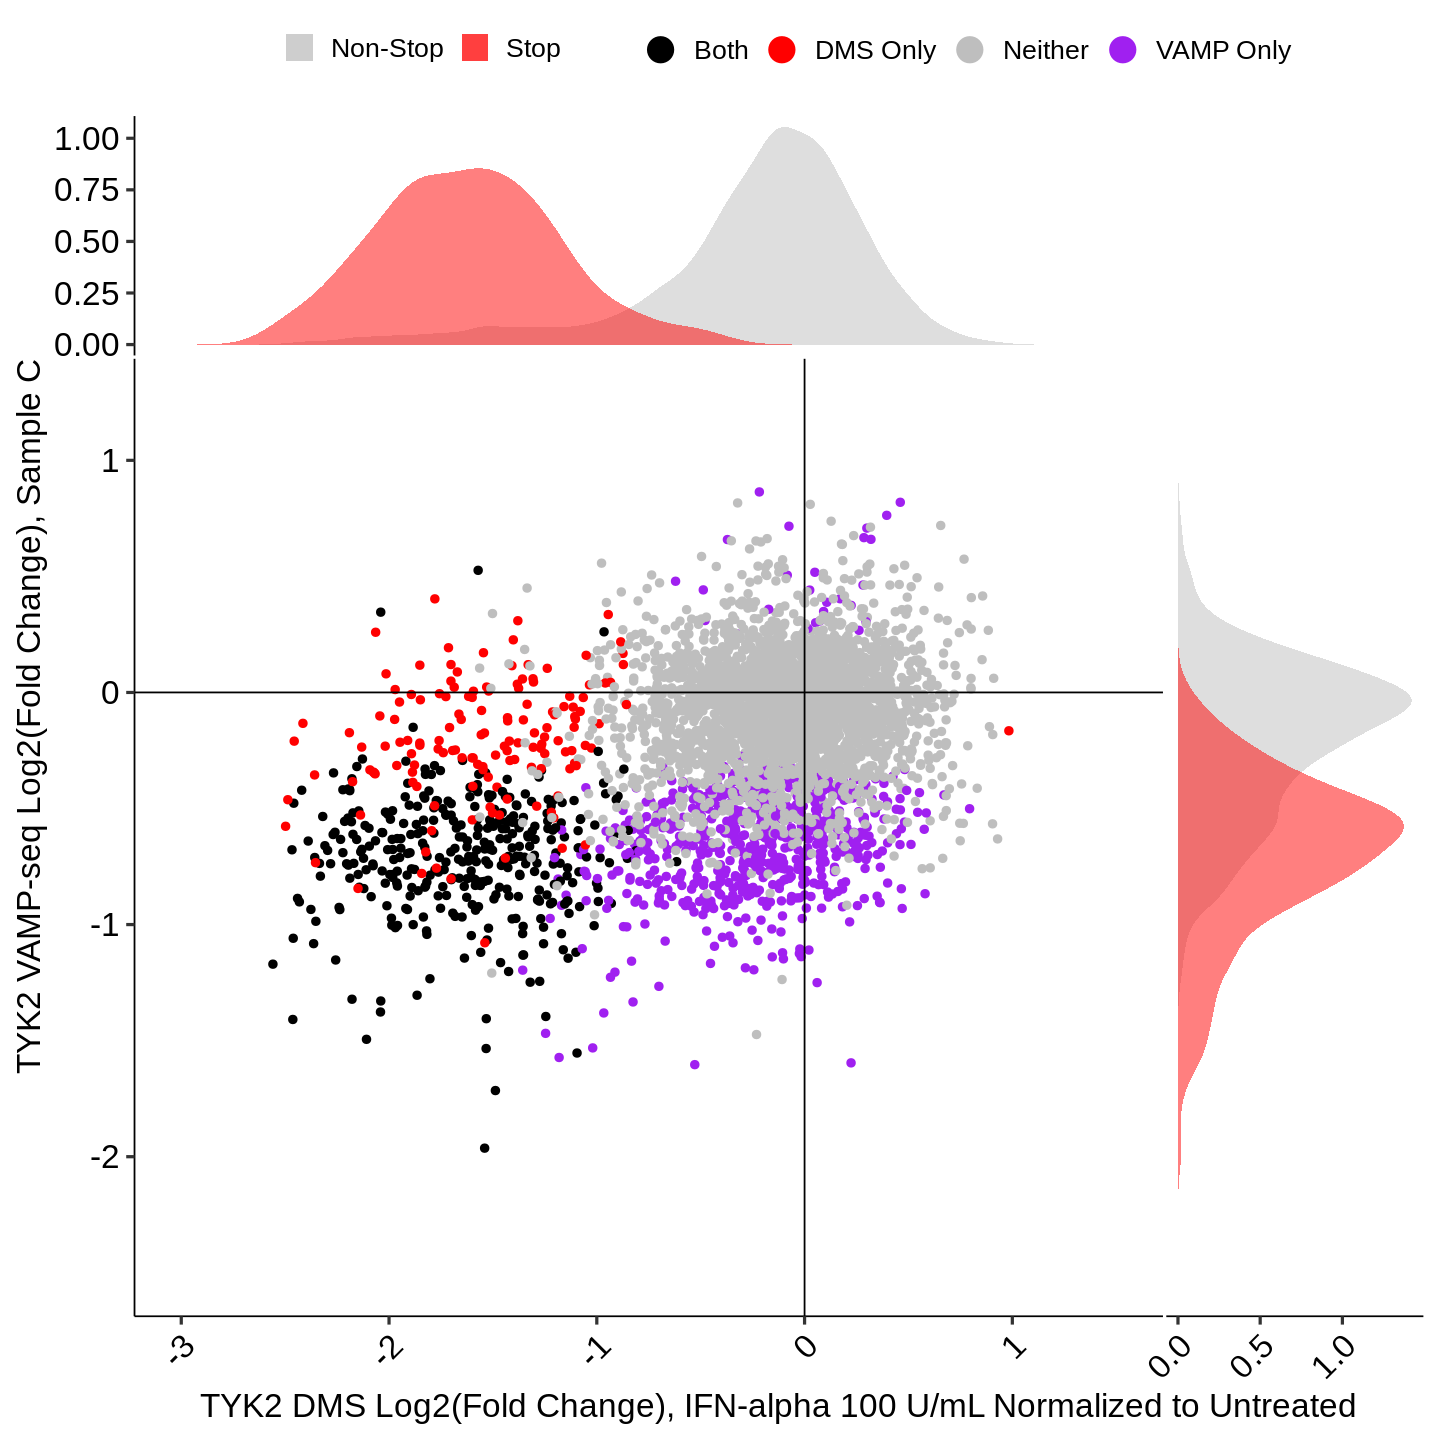

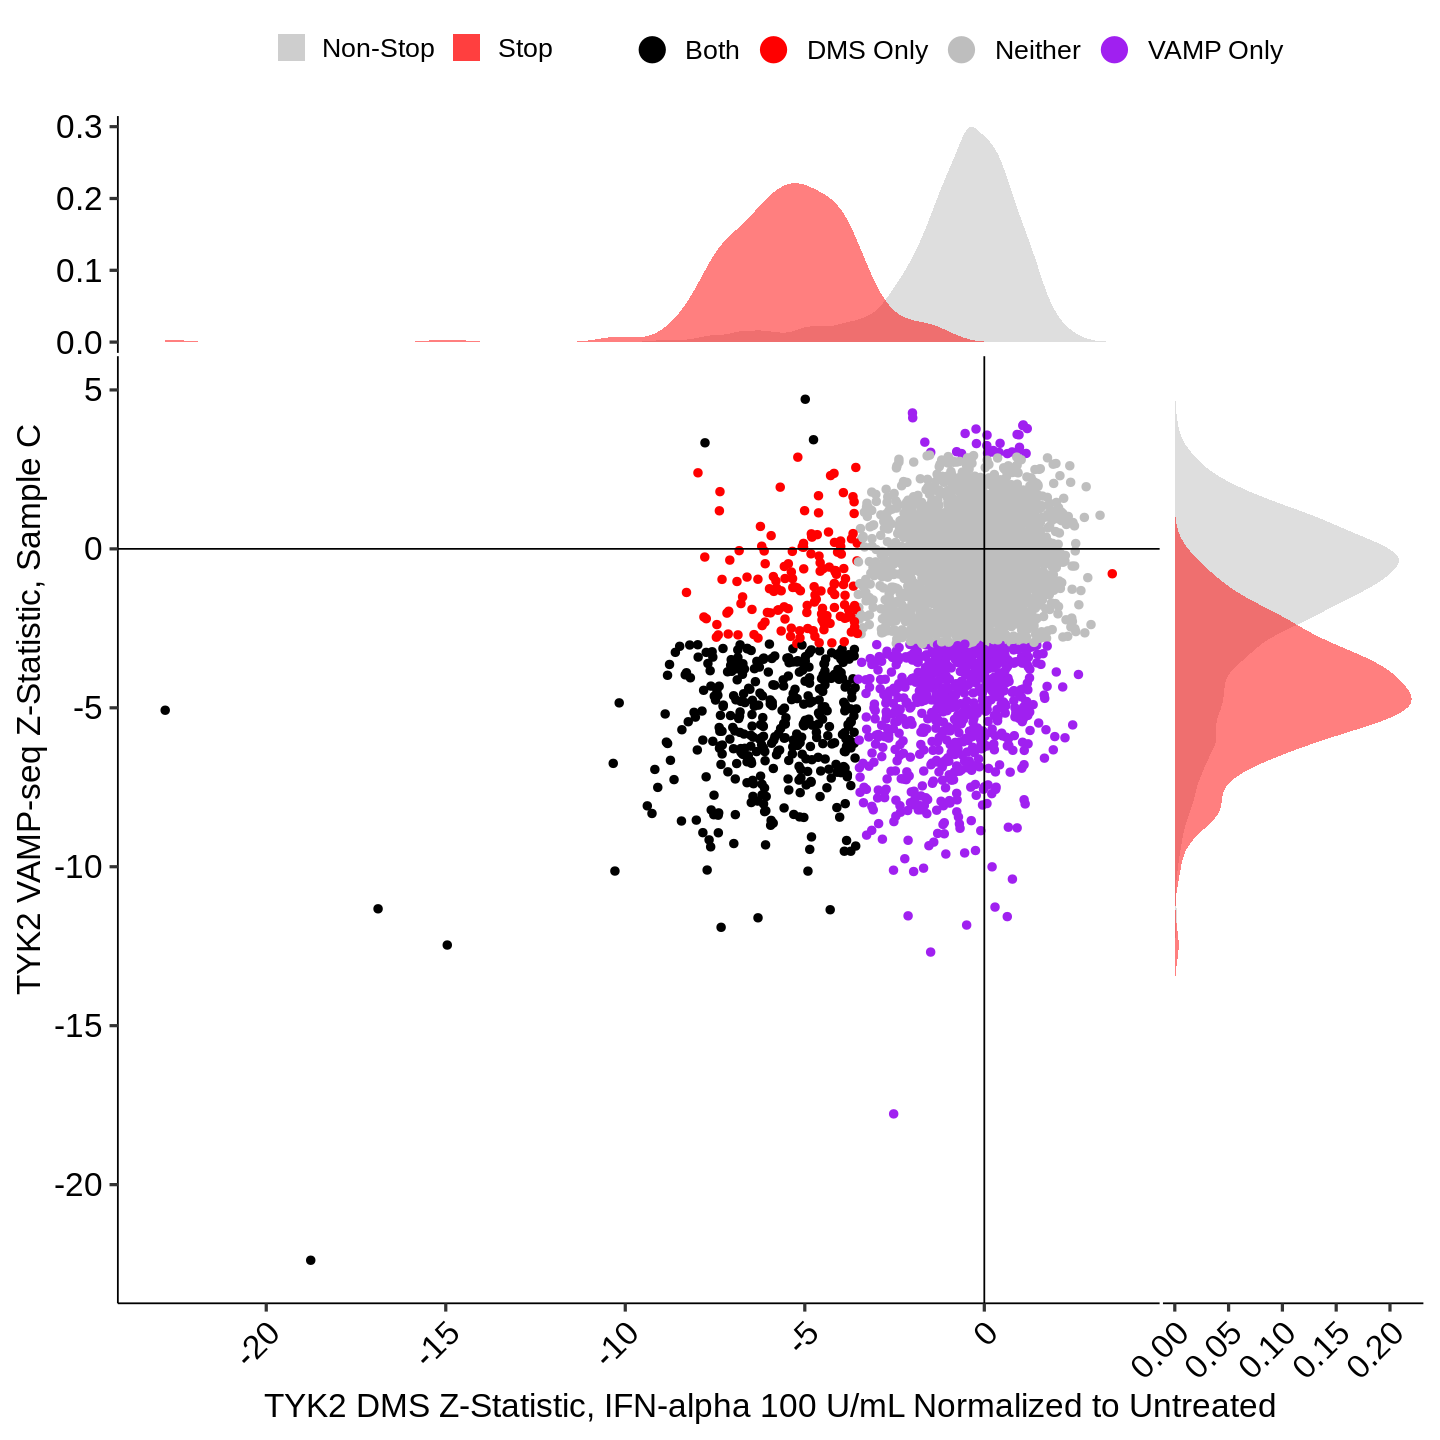

In [27]:
options(repr.plot.width = 12, repr.plot.height = 12)
l2fc_compare <- combined %>%
    mutate(`Stop Group` = if_else(aa == "*", "Stop", "Non-Stop")) %>%
    ggplot(aes(x = estimate.x, y = estimate.y, color = group)) +
        geom_point(size = 2) +
        xlim(c(-3,1.5)) + ylim(c(-2.5,1.25)) +
        theme_pubr(base_size = 20, x.text.angle = 45) +
        scale_color_manual(values = c("Both" = "black", "Neither" = "gray",
                                      "DMS Only" = "red", "VAMP Only" = "purple")) +
        theme(legend.title = element_blank()) + 
        guides(colour = guide_legend(override.aes = list(size=7))) +
        geom_hline(yintercept = 0) + geom_vline(xintercept = 0) +
        geom_xsidedensity(aes(y = after_stat(density),
                              fill = `Stop Group`), color = NA, alpha = 0.5) +
        geom_ysidedensity(aes(x = after_stat(density),
                              fill =`Stop Group`), color = NA, alpha = 0.5) +
        scale_xsidey_continuous() +
        scale_ysidex_continuous() +
        theme(ggside.panel.scale.x = 0.25,
              ggside.panel.scale.y = 0.25) +
        scale_fill_manual(values = c("Stop" = "red", "Non-Stop" = "gray")) +
        guides(colour = guide_legend(override.aes = list(size=7))) +
        xlab("TYK2 DMS Log2(Fold Change), IFN-alpha 100 U/mL Normalized to Untreated") + ylab("TYK2 VAMP-seq Log2(Fold Change), Sample C")

z_compare <- combined %>%
    mutate(`Stop Group` = if_else(aa == "*", "Stop", "Non-Stop")) %>%
    ggplot(aes(x = statistic.x, y = statistic.y, color = group)) +
        geom_point(size = 2) +
        theme_pubr(base_size = 20, x.text.angle = 45) +
        scale_color_manual(values = c("Both" = "black", "Neither" = "gray",
                                      "DMS Only" = "red", "VAMP Only" = "purple")) +
        theme(legend.title = element_blank()) + 
        guides(colour = guide_legend(override.aes = list(size=7))) +
        geom_hline(yintercept = 0) + geom_vline(xintercept = 0) +
        geom_xsidedensity(aes(y = after_stat(density),
                              fill = `Stop Group`), color = NA, alpha = 0.5) +
        geom_ysidedensity(aes(x = after_stat(density),
                              fill =`Stop Group`), color = NA, alpha = 0.5) +
        theme(ggside.panel.scale.x = 0.25,
              ggside.panel.scale.y = 0.25) +
        scale_fill_manual(values = c("Stop" = "red", "Non-Stop" = "gray")) +
        guides(colour = guide_legend(override.aes = list(size=7))) +
        xlab("TYK2 DMS Z-Statistic, IFN-alpha 100 U/mL Normalized to Untreated") + ylab("TYK2 VAMP-seq Z-Statistic, Sample C")
    

l2fc_compare
z_compare

ggsave("../dataviz/TYK2/vampseq/TYK2-IFNaDMS-VAMP-L2FC.pdf",
       l2fc_compare,
       height = 12,
       width = 12)

ggsave("../dataviz/TYK2/vampseq/TYK2-IFNaDMS-VAMP-Z.pdf",
       z_compare,
       height = 12,
       width = 12)


This is consistent with what we observe visually in the heatmaps - the VAMP-seq signal (particularly in chunks 10 and 14) is much broader than the DMS signal. There are also several variants that strongly deviate between the two assays, with the strongest such cases being those that are neutral in DMS but highly negative in VAMP-seq. Let's pull out that extreme variant, which is I684S:

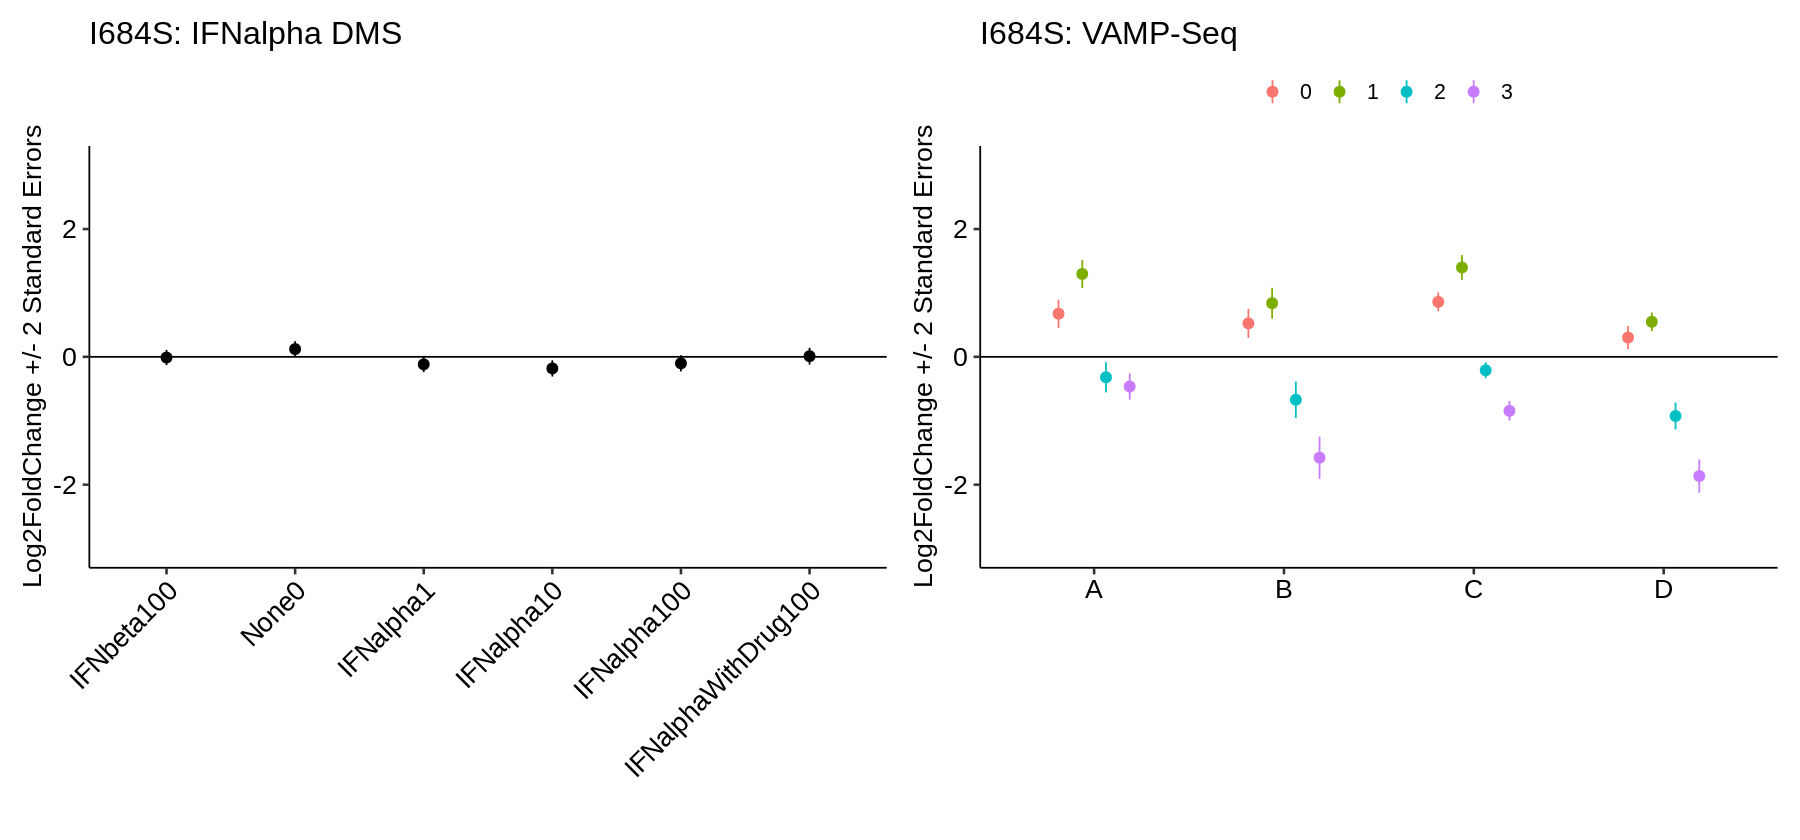

In [30]:
options(repr.plot.width = 15, repr.plot.height = 7)

dms_raw_sumstat <- dms_full %>% filter(pos == 684, aa == "S") %>%
    ggplot() +
        geom_pointrange(aes(x = condition, y = estimate, 
                            ymin = estimate - 2*std.error, ymax = estimate + 2*std.error)) +
        theme_pubr(base_size = 16, x.text.angle = 45) + ylim(c(-3, 3)) +
        geom_hline(yintercept = 0) + ggtitle("I684S: IFNalpha DMS") + xlab("") +
        ylab("Log2FoldChange +/- 2 Standard Errors")

vamp_raw_sumstat <- vamp_full %>% filter(pos == 684, aa == "S") %>%
    ggplot() +
        geom_pointrange(aes(x = sample, color = as.factor(bin), fill = as.factor(bin), y = estimate, 
                            ymin = estimate - 2*std.error, ymax = estimate + 2*std.error),
                        position = position_dodge(width = 0.5)) +
        theme_pubr(base_size = 16) + ylim(c(-3, 3)) +
        geom_hline(yintercept = 0) + ggtitle("I684S: VAMP-Seq") + xlab("") +
        ylab("Log2FoldChange +/- 2 Standard Errors") +
        theme(legend.title = element_blank())

dms_raw_sumstat + vamp_raw_sumstat

There are also several variants which are signifiacant at a 1% FDR in both assays, but switch direction. Let's extract and profile those next:

In [31]:
mut_vec <- combined %>% 
    filter(group == "Both", sign(estimate.x) != sign(estimate.y)) %>%
    select(pos, aa) %>%
    mutate(mut_id = paste0(pos, aa)) %>%
    pull(mut_id)

dms_raw_sumstat_rev <- dms_full %>% filter(paste0(pos, aa) %in% mut_vec) %>%
    ggplot() +
        geom_pointrange(aes(x = condition, y = estimate, 
                            ymin = estimate - 2*std.error, ymax = estimate + 2*std.error)) +
        theme_pubr(base_size = 16, x.text.angle = 45) + ylim(c(-3, 3)) +
        geom_hline(yintercept = 0) + ggtitle("IFNalpha DMS") + xlab("") +
        ylab("Log2FoldChange +/- 2 Standard Errors") +
        facet_wrap(~paste0(pos, aa), ncol = 1)

vamp_raw_sumstat_rev <- vamp_full %>% filter(paste0(pos, aa) %in% mut_vec) %>%
    ggplot() +
        geom_pointrange(aes(x = sample, color = as.factor(bin), fill = as.factor(bin), y = estimate, 
                            ymin = estimate - 2*std.error, ymax = estimate + 2*std.error),
                        position = position_dodge(width = 0.5)) +
        theme_pubr(base_size = 16) + ylim(c(-3, 3)) +
        geom_hline(yintercept = 0) + ggtitle("VAMP-Seq") + xlab("") +
        geom_rect(aes(xmin = 2.5, xmax = 3.5, ymin = -3, ymax = 3), color = "black", fill = NA, alpha = 0) +
        ylab("Log2FoldChange +/- 2 Standard Errors") +
        theme(legend.title = element_blank()) +
        facet_wrap(~paste0(pos, aa), ncol = 1)

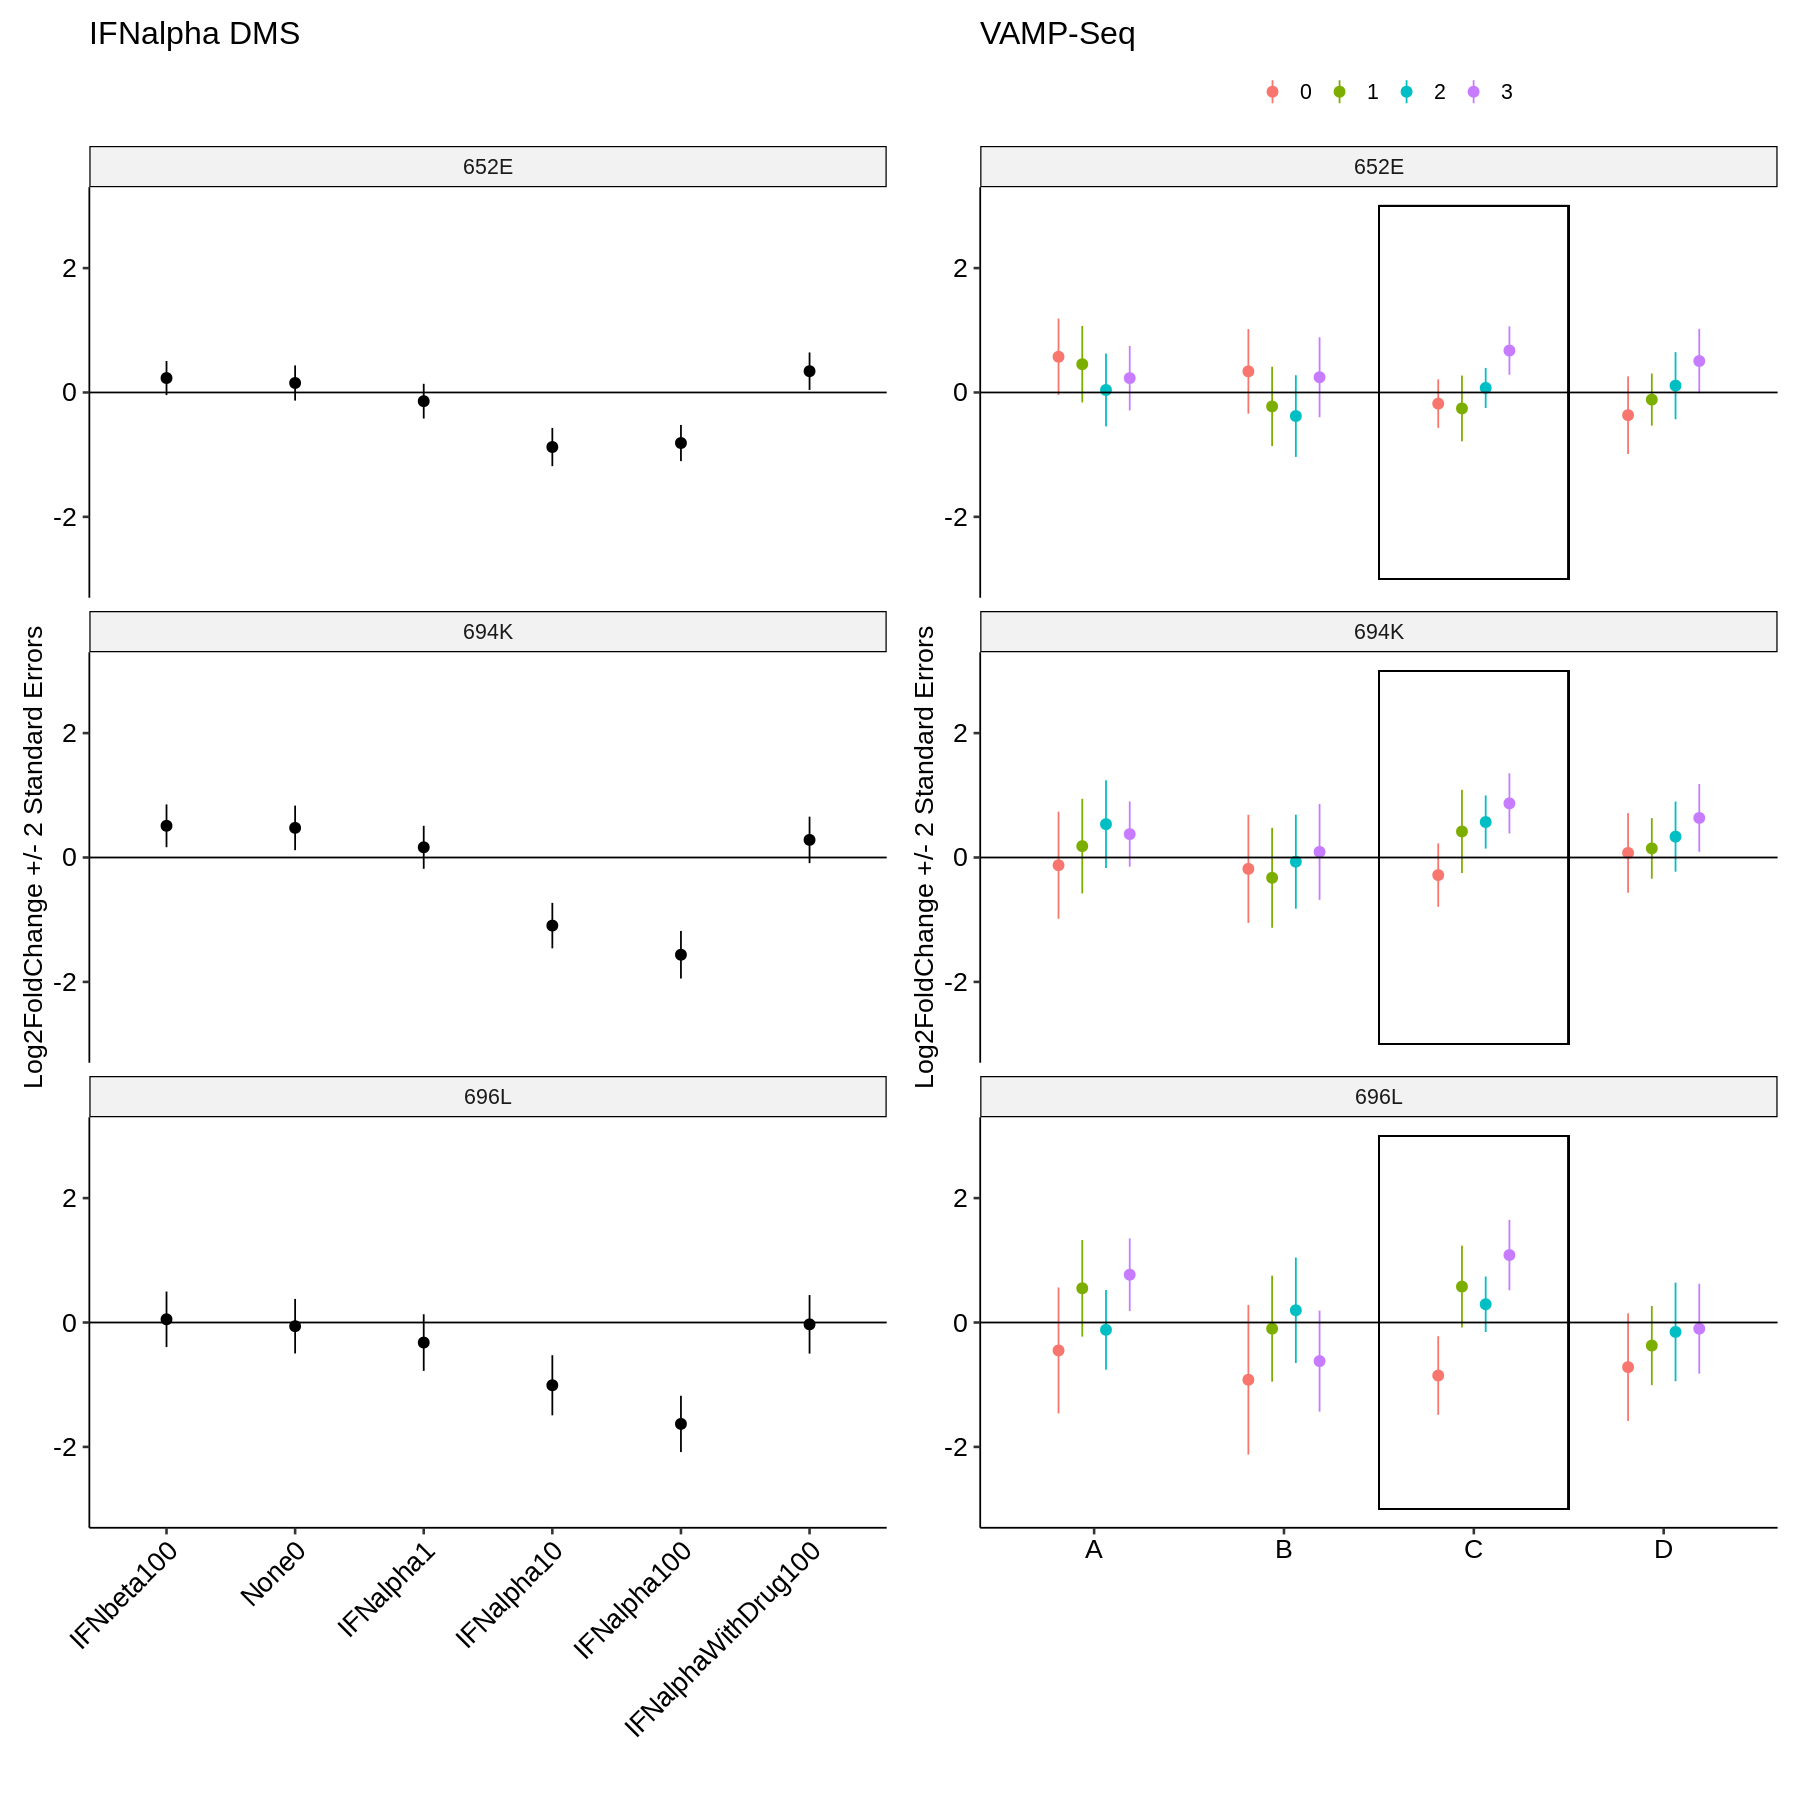

In [32]:
options(repr.plot.width = 15, repr.plot.height = 15)
dms_raw_sumstat_rev + vamp_raw_sumstat_rev

#### Contrast and Pairwise Correlations <a name="part2"></a>



In [33]:
compute_difference <- function(test, control, sumstats) {
    
    df1 <- sumstats %>% filter(condition == test) %>% select(-condition)
    df2 <- sumstats %>% filter(condition == control) %>% select(-condition)
    
    df <- inner_join(df1, df2,
                     by = c("pos", "chunk", "aa"))
    
    new_stats <- df %>%
        mutate(estimate = estimate.x - estimate.y,
               std.error = sqrt(std.error.x^2 + std.error.y^2),) %>%
        select(pos, chunk, aa, estimate, std.error) %>%
        ungroup()
    
    new_stats$condition = paste0(test, " - ", control)
    
    return(new_stats)
    
}

In [34]:
dms_vamp_contrast <- bind_rows(
    dms %>%
        filter(chunk %in% c(3, 10, 14)) %>%
        select(pos, chunk, aa, estimate, std.error) %>%
        mutate(condition = "DMS"),
    vamp %>%
        filter(chunk %in% c(3, 10, 14)) %>%
        select(pos, chunk, aa, estimate, std.error)  %>%
        mutate(condition = "VAMP",
               estimate = estimate * 3,
               std.error = std.error * 3)
)

dms_vamp_contrast_sumstat <- compute_difference(dms_vamp_contrast,
                                                test = "VAMP",
                                                control = "DMS")  %>%
    mutate(statistic = estimate / std.error,
           p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                                 (1-pnorm(statistic, sd = 1))*2),
           p.adj = p.adjust(p.value, method = "BH"))

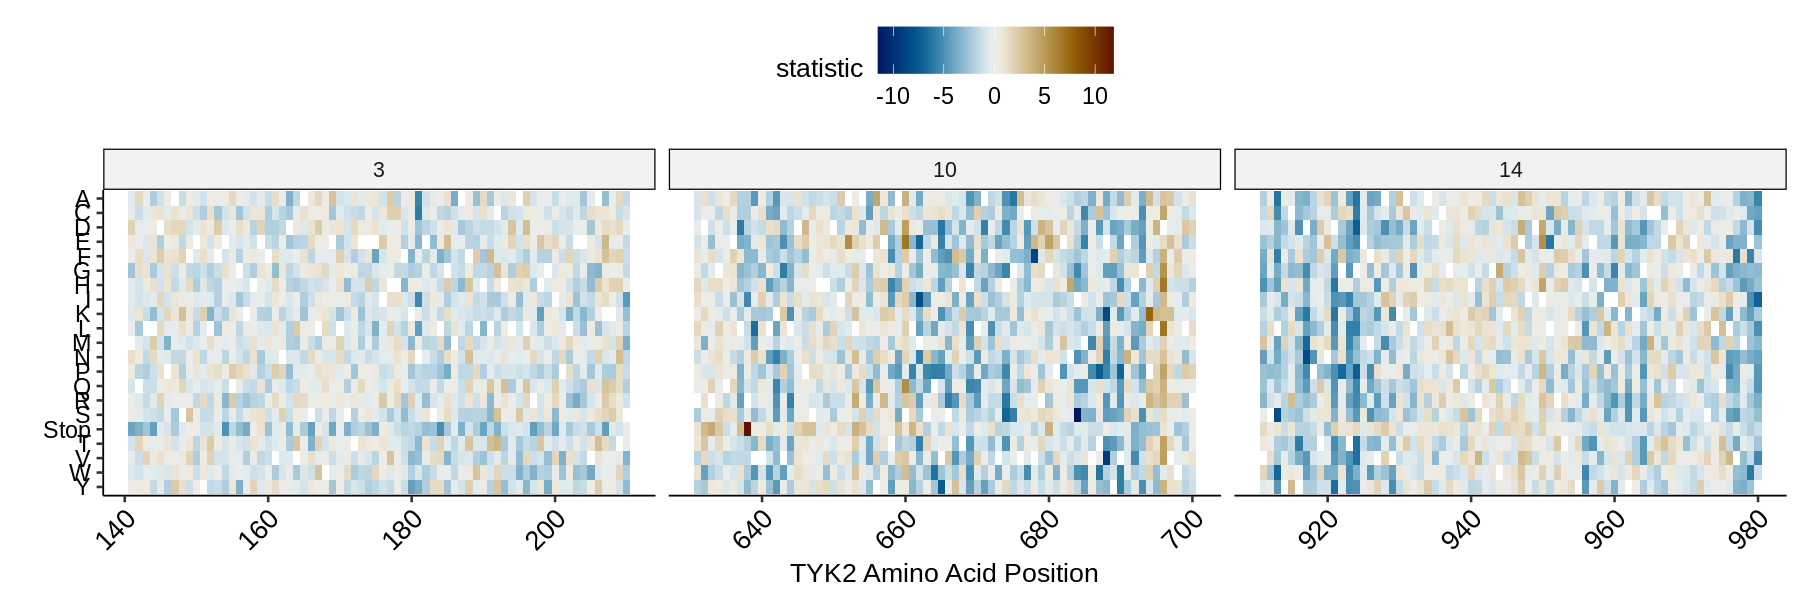

In [35]:
options(repr.plot.width = 15, repr.plot.height = 5)
dms_vamp_contrast_sumstat %>% 
    mutate(aa = if_else(aa == "*", "Stop", aa)) %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill = statistic)) +
            scale_fill_scico_mid(palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~as.numeric(chunk), scales = "free_x")

pos chunk aa estimate std.error condition  statistic p.value     
1  638 10    *  1.433331 0.1212419 VAMP - DMS 11.822082 0.000000e+00
2  694 10    K  3.077613 0.4067985 VAMP - DMS  7.565448 3.863576e-14
3  660 10    E  2.842491 0.4156396 VAMP - DMS  6.838836 7.983836e-12
4  696 10    L  3.149479 0.4601242 VAMP - DMS  6.844846 7.655876e-12
5  696 10    H  2.062465 0.3058917 VAMP - DMS  6.742469 1.557177e-11
6  652 10    E  1.748647 0.3053662 VAMP - DMS  5.726395 1.025873e-08
7  660 10    Q  2.204317 0.3868810 VAMP - DMS  5.697663 1.214607e-08
8  950 14    E  2.989064 0.5415613 VAMP - DMS  5.519346 3.402631e-08
9  696 10    G  2.291883 0.4238188 VAMP - DMS  5.407695 6.384108e-08
10 660 10    D  1.535333 0.3237177 VAMP - DMS  4.742815 2.107685e-06
   p.adj       
1  0.000000e+00
2  1.802573e-11
3  1.676206e-09
4  1.676206e-09
5  2.842863e-09
6  7.977113e-07
7  8.947603e-07
8  1.984396e-06
9  3.309490e-06
10 5.754518e-05

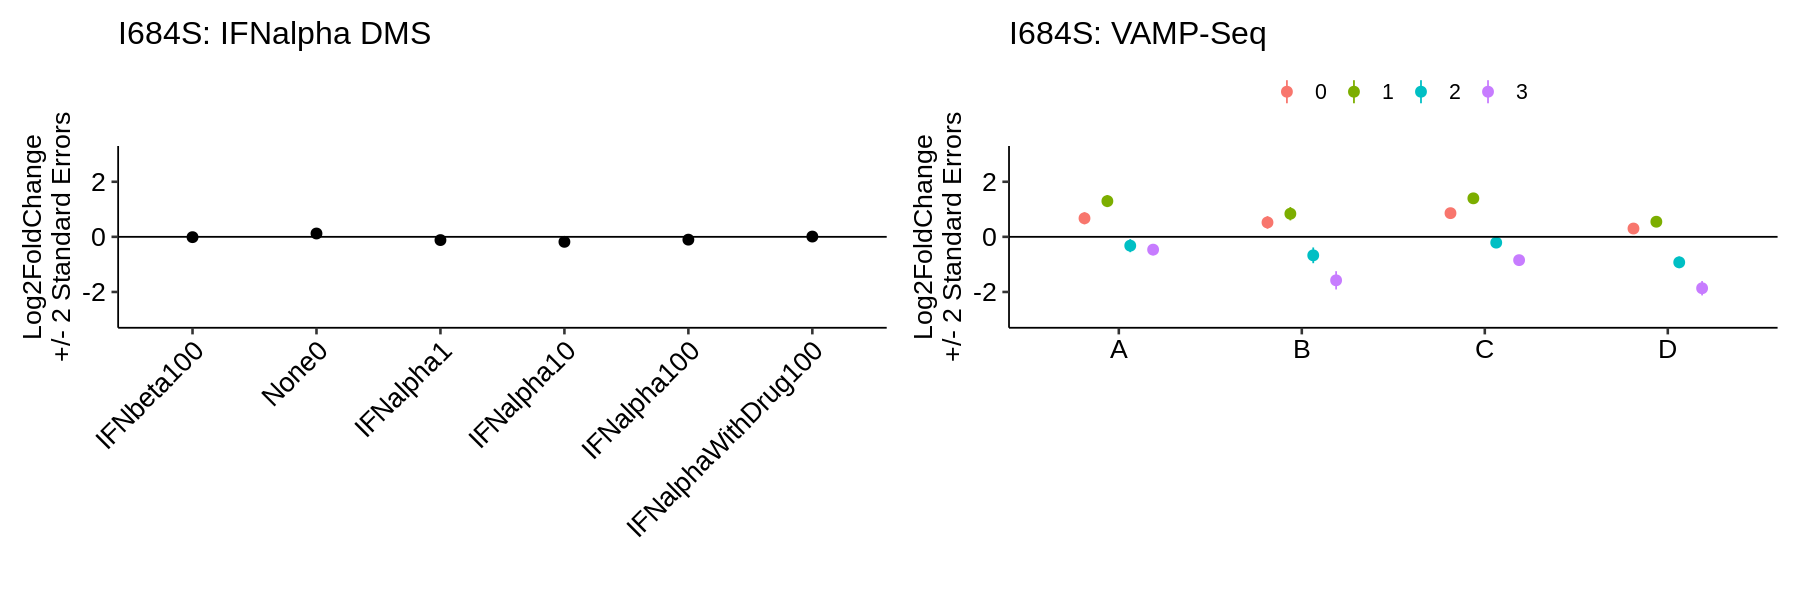

In [50]:
dms_vamp_contrast_sumstat %>% filter(estimate > 0) %>%
    arrange(p.adj) %>% 
    head(10)

dms_raw_sumstat <- dms_full %>% filter(pos == 684, aa == "S") %>%
    ggplot() +
        geom_pointrange(aes(x = condition, y = estimate, 
                            ymin = estimate - 2*std.error, ymax = estimate + 2*std.error)) +
        theme_pubr(base_size = 16, x.text.angle = 45) + ylim(c(-3, 3)) +
        geom_hline(yintercept = 0) + ggtitle("I684S: IFNalpha DMS") + xlab("") +
        ylab("Log2FoldChange\n+/- 2 Standard Errors")

vamp_raw_sumstat <- vamp_full %>% filter(pos == 684, aa == "S") %>%
    ggplot() +
        geom_pointrange(aes(x = sample, color = as.factor(bin), fill = as.factor(bin), y = estimate, 
                            ymin = estimate - 2*std.error, ymax = estimate + 2*std.error),
                        position = position_dodge(width = 0.5)) +
        theme_pubr(base_size = 16) + ylim(c(-3, 3)) +
        geom_hline(yintercept = 0) + ggtitle("I684S: VAMP-Seq") + xlab("") +
        ylab("Log2FoldChange\n+/- 2 Standard Errors") +
        theme(legend.title = element_blank())

options(repr.plot.width = 15, repr.plot.height = 5)
dms_raw_sumstat + vamp_raw_sumstat

In [38]:
dms_vamp <- bind_rows(
    dms_full %>% filter(chunk %in% c(3, 10, 14)) %>% select(chunk, pos, condition, aa, statistic) %>% mutate(chunk = as.numeric(chunk)),
    vamp_full %>% filter(chunk %in% c(3, 10, 14)) %>% select(chunk, pos, condition, aa, statistic)) %>%
    #mutate(statistic = if_else(abs(statistic) > 10, 10*sign(statistic), statistic)) %>%
    pivot_wider(names_from = condition, values_from = statistic, values_fill = 0)

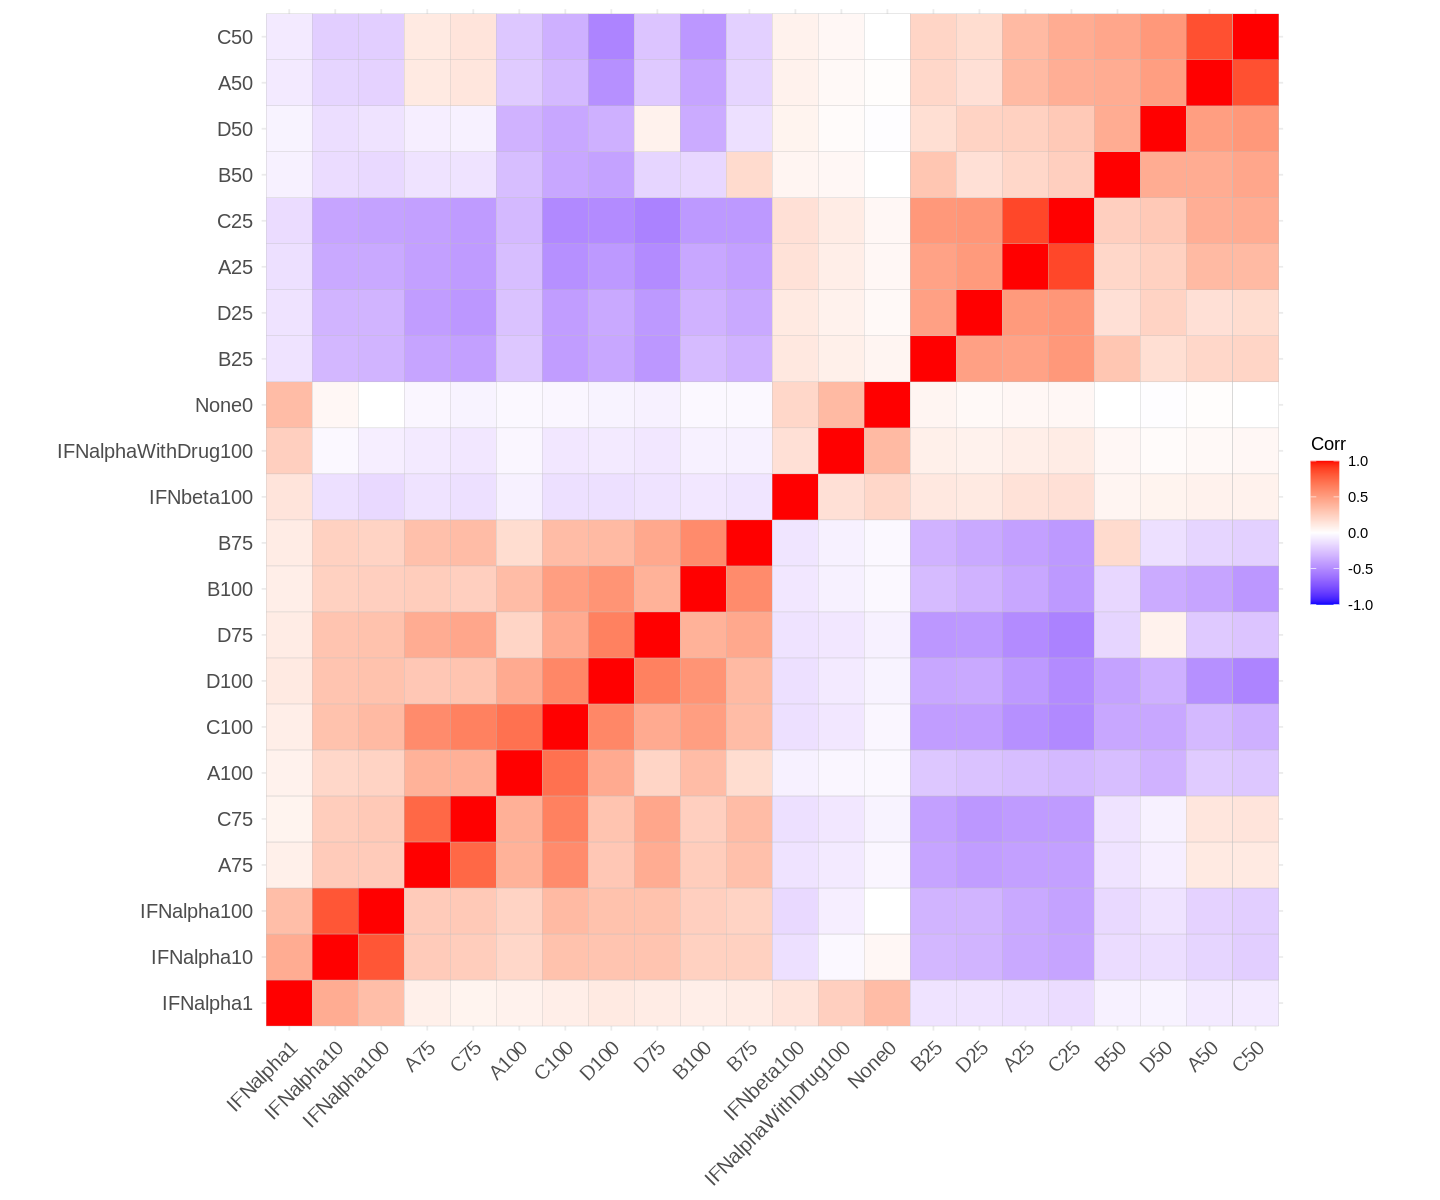

In [44]:
options(repr.plot.width = 12, repr.plot.height = 10)
ggcorrplot(cor(dms_vamp[,-1:-3]), hc.order = TRUE)

#### Dimensional Projections <a name="part3"></a>

Two very simple projections we can apply are t-SNE (non-linear) and PCA (traditional and linear), shown below in that order and with stops shown in red in all plots:

In [67]:
mat <- as.matrix(dms_vamp[,-1:-3])
tsneobj <- Rtsne(mat)
projections <- as_tibble(tsneobj$Y) %>% mutate(pos = dms_vamp$pos, aa = dms_vamp$aa)

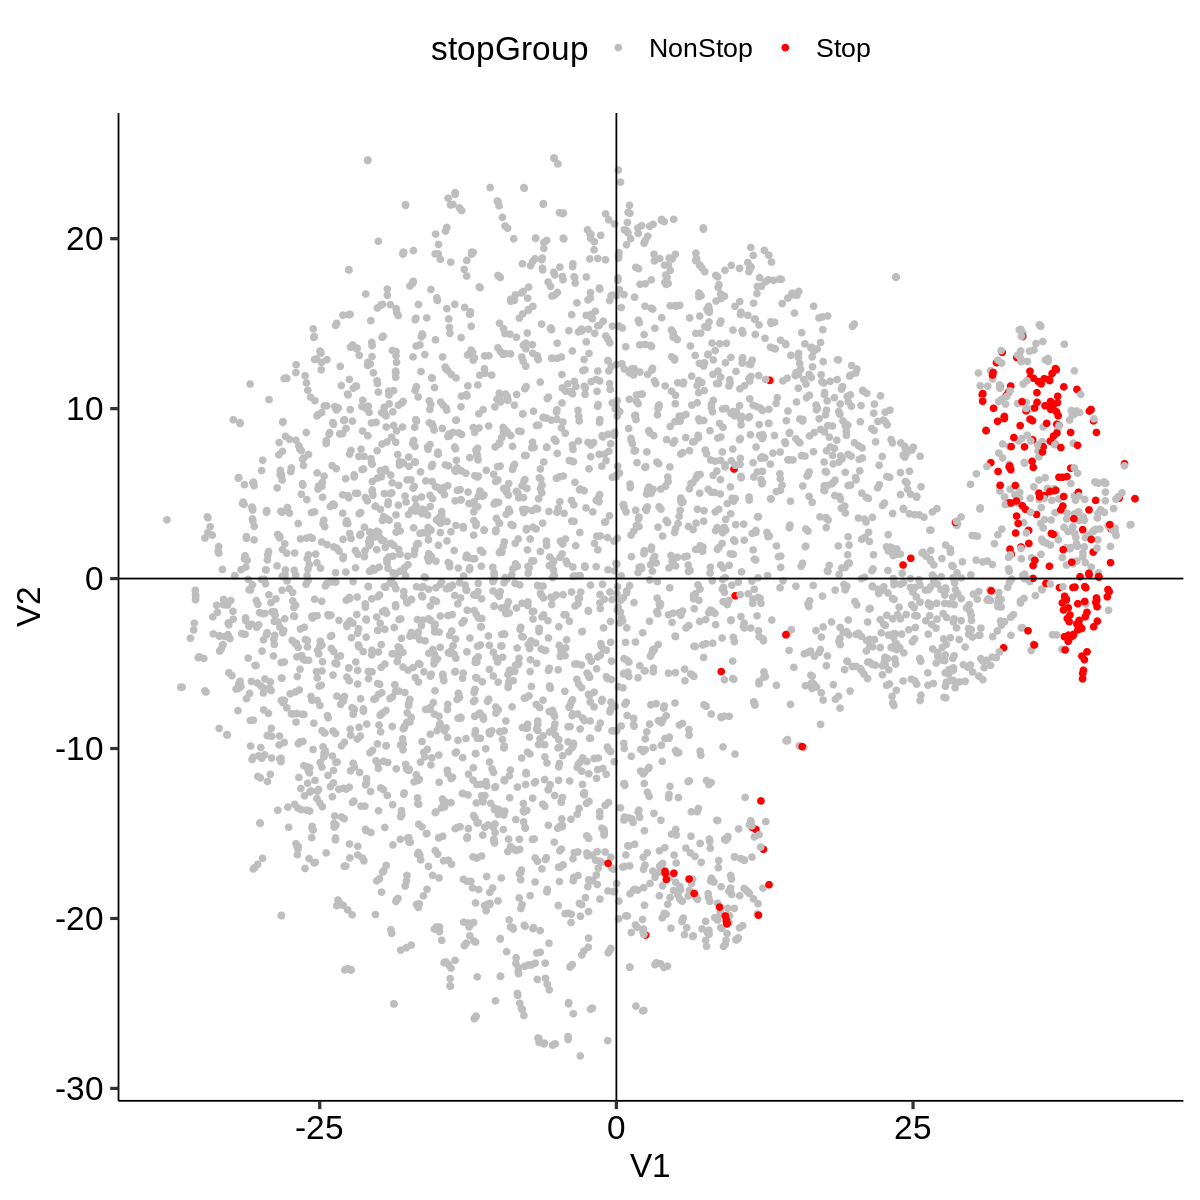

In [68]:
options(repr.plot.width = 10, repr.plot.height = 10)
projections %>%
    mutate(stopGroup = if_else(aa == "*", "Stop", "NonStop")) %>%
    ggplot() +
        geom_point(aes(x = V1, y = V2, color = stopGroup)) +
        theme_pubr(base_size = 20) +
        scale_color_manual(values = c("Stop" = "red", "NonStop" = "gray")) +
        geom_hline(yintercept = 0) +
        geom_vline(xintercept = 0)

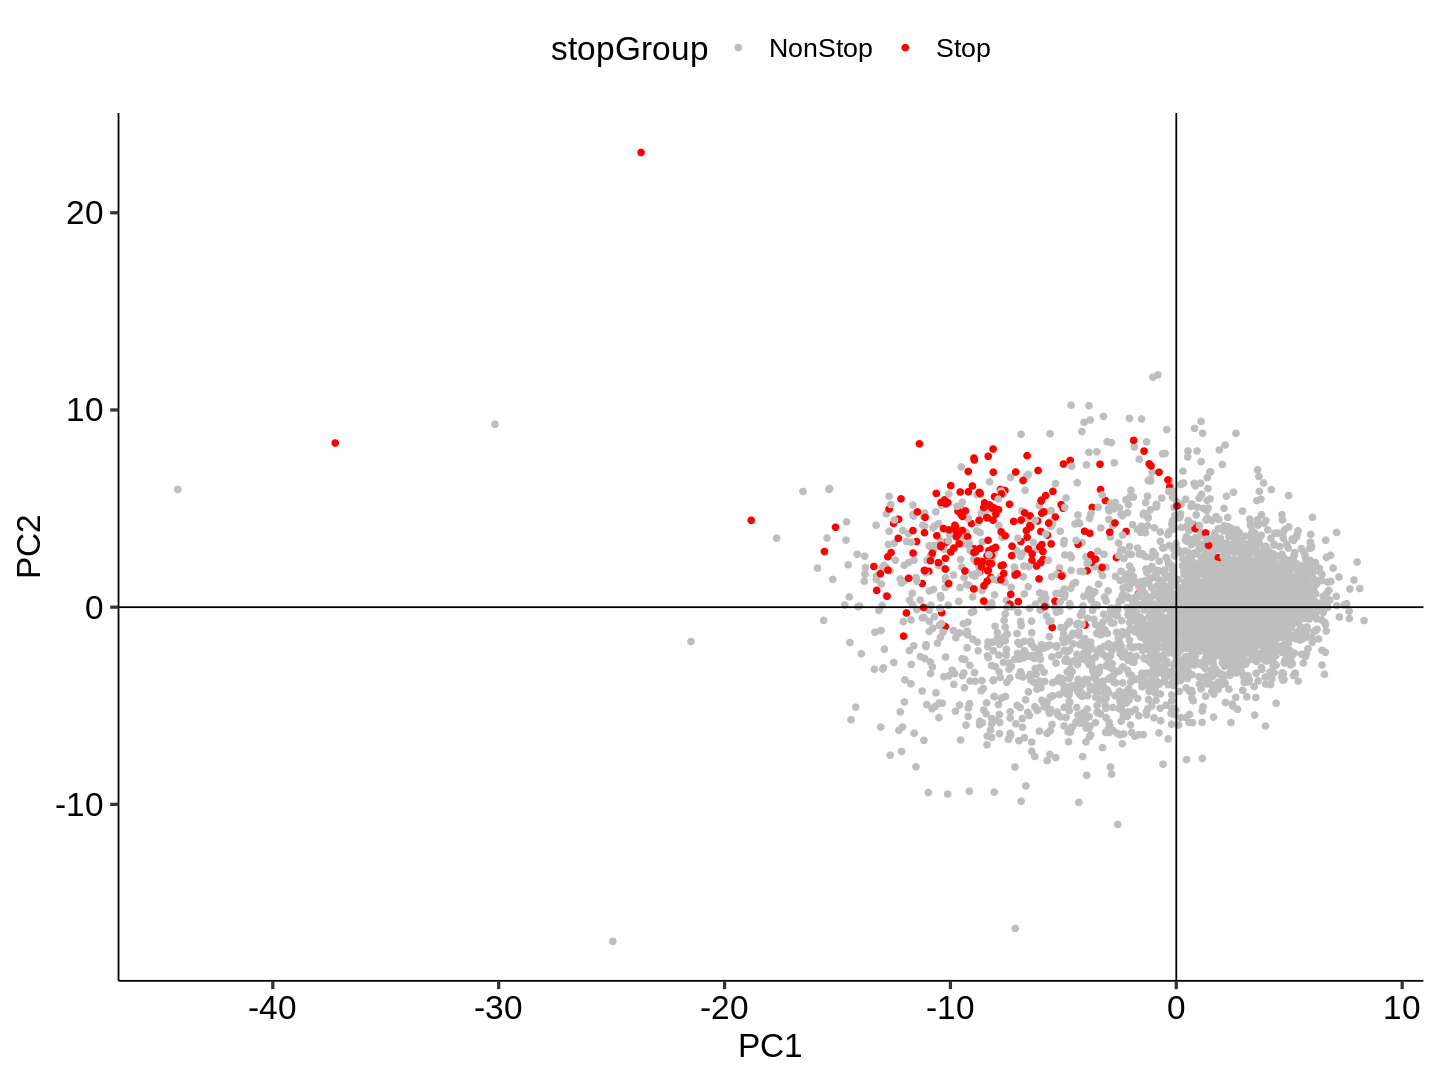

In [69]:
probj <- prcomp(dms_vamp[,-1:-3])
projections <- as_tibble(probj$x) %>% mutate(pos = dms_vamp$pos,
                                             aa = dms_vamp$aa,
                                             chunk = dms_vamp$chunk)
loadings <- as_tibble(probj$rotation) %>%
    mutate(condition = names(dms_vamp[,-1:-3]))

options(repr.plot.width = 12, repr.plot.height = 9)
projections %>%
    mutate(stopGroup = if_else(aa == "*", "Stop", "NonStop")) %>%
    ggplot() +
        geom_point(aes(x = PC1, y = PC2, color = stopGroup)) +
        theme_pubr(base_size = 20) +
        scale_color_manual(values = c("Stop" = "red", "NonStop" = "gray")) +
        geom_hline(yintercept = 0) +
        geom_vline(xintercept = 0)

In this particular PCA, the first two components explain ~90% of the variance, and the first four get up to ~99%. We can show those four components across the heatmap grid as intensities:

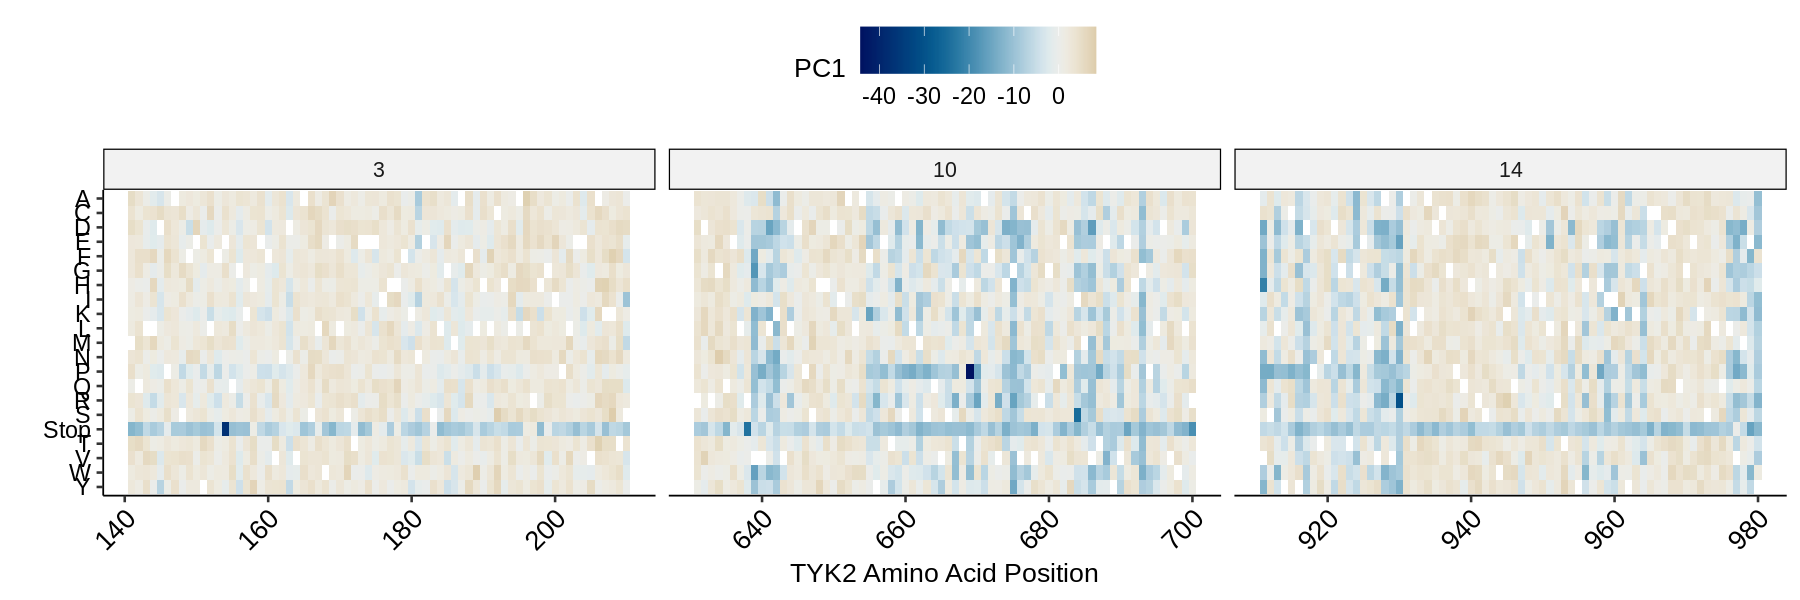

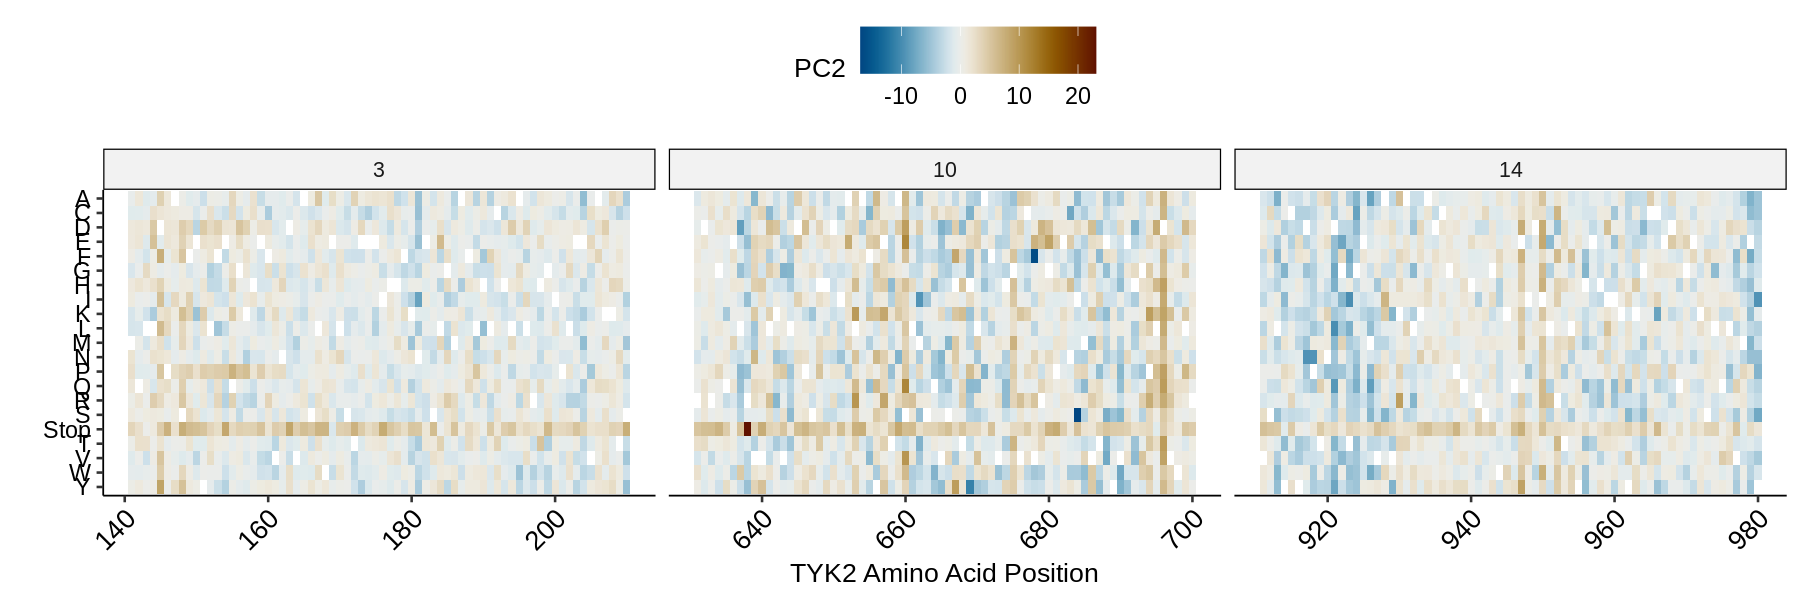

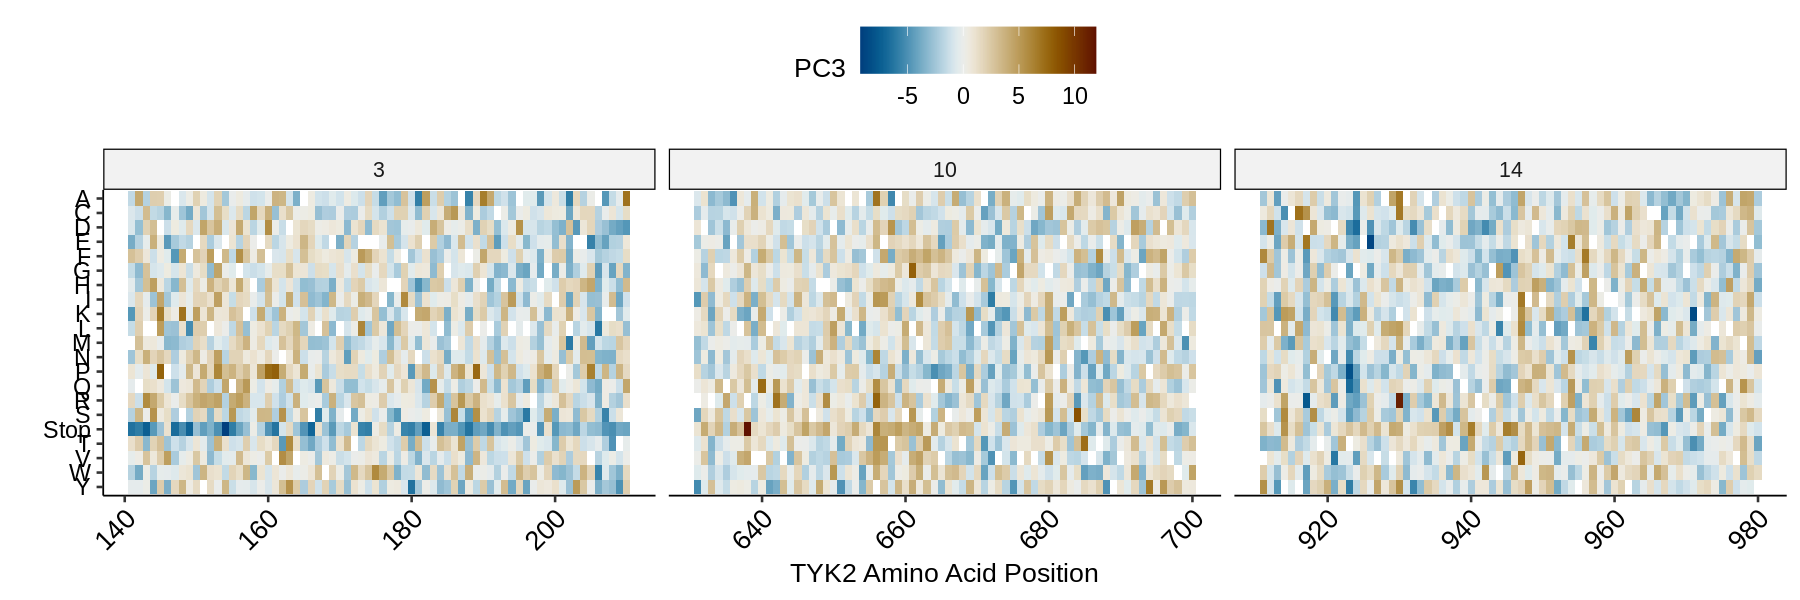

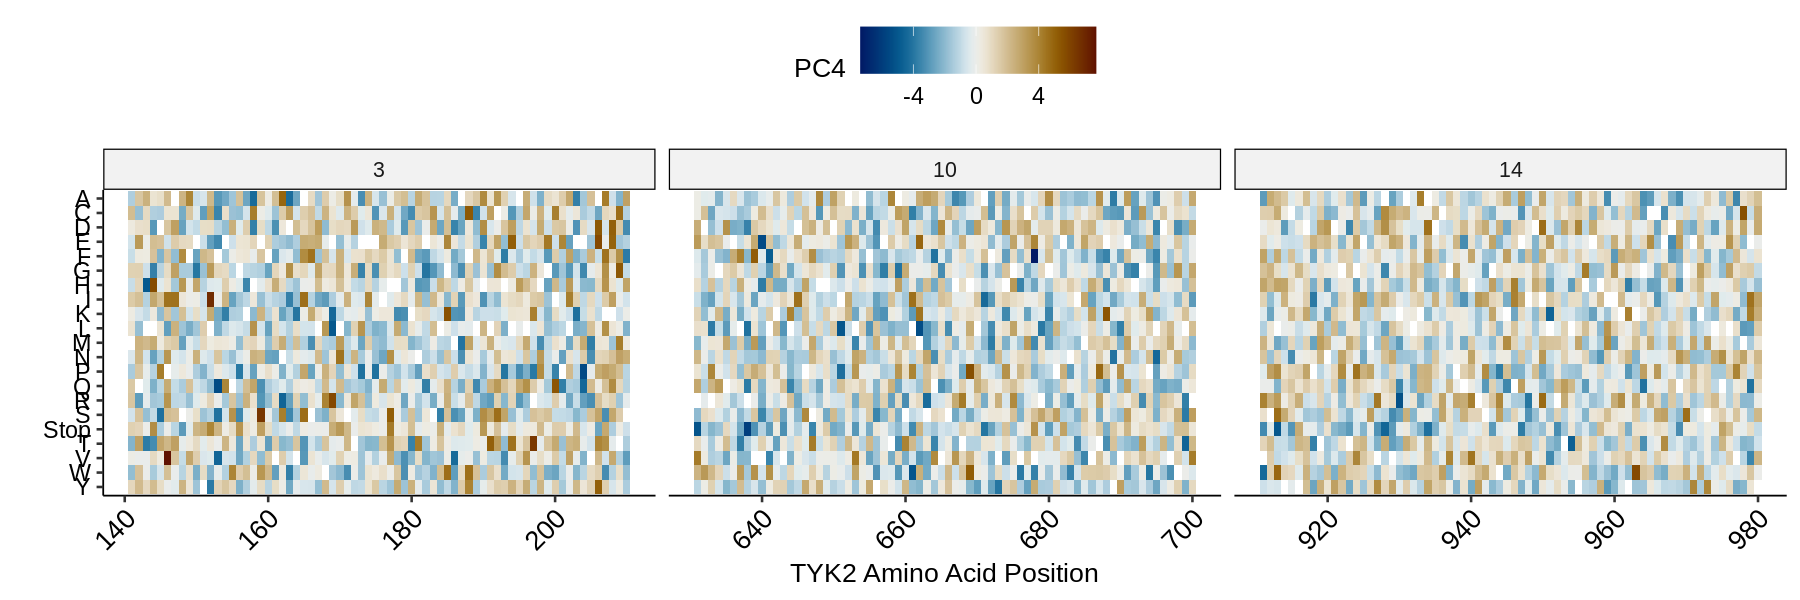

In [70]:
options(repr.plot.width = 15, repr.plot.height = 5)
ggplot(projections %>% mutate(aa = if_else(aa == "*", "Stop", aa))) +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill = PC1)) +
            scale_fill_scico_mid(palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~chunk, scales = "free_x")

ggplot(projections %>% mutate(aa = if_else(aa == "*", "Stop", aa))) +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill = PC2)) +
            scale_fill_scico_mid(palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~chunk, scales = "free_x")

ggplot(projections %>% mutate(aa = if_else(aa == "*", "Stop", aa))) +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill = PC3)) +
            scale_fill_scico_mid(palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~chunk, scales = "free_x")

ggplot(projections %>% mutate(aa = if_else(aa == "*", "Stop", aa))) +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill = PC4)) +
            scale_fill_scico_mid(palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~chunk, scales = "free_x")

We can also invert this view, and instead of considering each variant as a vector across all our conditions and assays, we can instead consider each sample as a vector across all tested variants. Doing so puts each sample into a reduced space with an informative pattern:

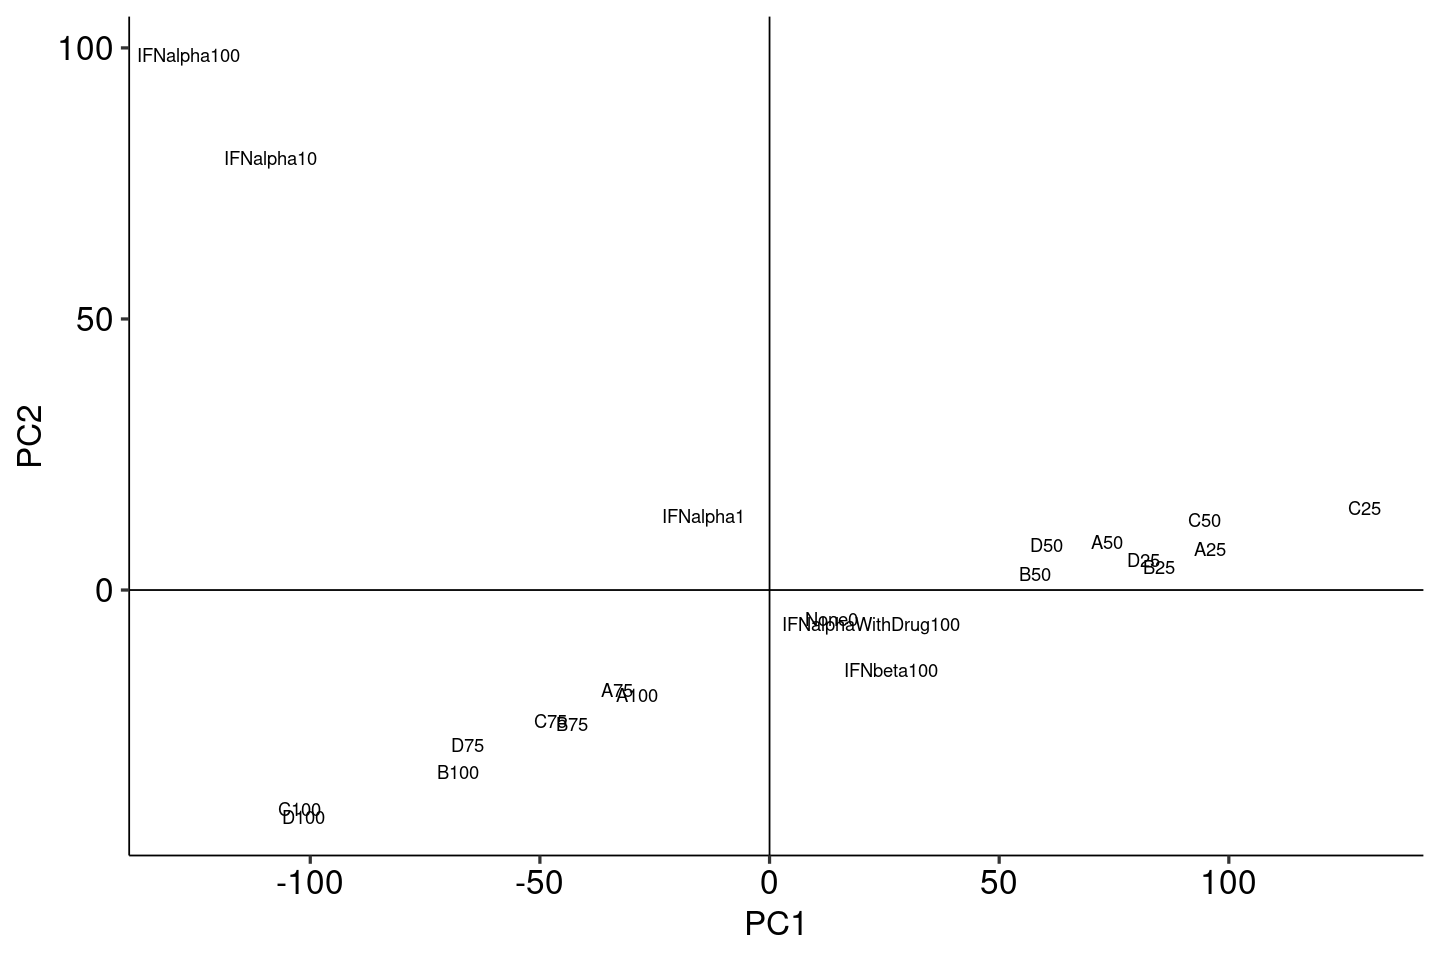

In [178]:
probj <- prcomp(t(dms_vamp[,-1:-2]))
projections <- as_tibble(probj$x) %>% mutate(condition = names(dms_vamp[,-1:-2]))

options(repr.plot.width = 12, repr.plot.height = 8)
projections %>%
    ggplot() +
        geom_text(aes(x = PC1, y = PC2, label = condition)) +
        theme_pubr(base_size = 20) +
        geom_hline(yintercept = 0) +
        geom_vline(xintercept = 0)

#### Biochemical Aggregation <a name="part4"></a>

Chemically, the structural range of encoded amino acids suggests several ways we can reduce the complexity of our data by combining groups of residues based on biochemical properties. Below are three previously used residue groupings, the first two applied to MC4R and the third applied to ADRB2:

In [3]:
aagroup1 <- read_tsv("../data/annotations/aaGroups.txt")
aagroup2 <- read_tsv("../data/annotations/aaGroups-alt.txt")
aagroup3 <- read_tsv("../data/annotations/aaGroups-adrb2.txt")

Rows: 8 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): aa, group

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 11 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): aa, group

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 9 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): aa, group

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
aagroup1 %>% arrange(group) %>% kable("markdown")
aagroup2 %>% arrange(group) %>% kable("markdown")
aagroup3 %>% arrange(group) %>% kable("markdown")



|aa            |group               |
|:-------------|:-------------------|
|N,Q           |Amide               |
|V,I,L,M,F,Y,W |AromaticHydrophobic |
|C             |Cysteine            |
|D,E           |Negative            |
|K,R,H         |Positive            |
|P             |Proline             |
|G,A,S,T       |SmallSerThr         |
|*             |Stop                |



|aa      |group            |
|:-------|:----------------|
|N,Q     |Amide            |
|F,Y,W,H |Aromatic         |
|C       |Cysteine         |
|V,I     |Hydrophobic1     |
|L,M     |Hydrophobic2     |
|D,E     |Negative         |
|K,R     |Positive         |
|P       |Proline          |
|S,T     |Serine/Threonine |
|G,A     |Small            |
|*       |Stop             |



|aa      |group         |
|:-------|:-------------|
|N,Q     |Amide         |
|F,W,Y   |Aromatic      |
|I,L,V,M |Hydrophobic   |
|D,E     |Negative      |
|C,S,T   |Nucleophillic |
|R,H,K   |Positive      |
|P       |Proline       |
|A,G     |Small         |
|*       |Stop          |

Joining these and pivoting highlights where they diverge:

In [9]:
groupings <- bind_rows(aagroup1 %>% mutate(set = "set1"),
          aagroup2 %>% mutate(set = "set2"),
          aagroup3 %>% mutate(set = "set3")) %>%
    separate_rows(aa, sep = ",") %>%
    pivot_wider(names_from = set, values_from = group)

groupings %>% kable("markdown")



|aa |set1                |set2             |set3          |
|:--|:-------------------|:----------------|:-------------|
|G  |SmallSerThr         |Small            |Small         |
|A  |SmallSerThr         |Small            |Small         |
|S  |SmallSerThr         |Serine/Threonine |Nucleophillic |
|T  |SmallSerThr         |Serine/Threonine |Nucleophillic |
|C  |Cysteine            |Cysteine         |Nucleophillic |
|P  |Proline             |Proline          |Proline       |
|V  |AromaticHydrophobic |Hydrophobic1     |Hydrophobic   |
|I  |AromaticHydrophobic |Hydrophobic1     |Hydrophobic   |
|L  |AromaticHydrophobic |Hydrophobic2     |Hydrophobic   |
|M  |AromaticHydrophobic |Hydrophobic2     |Hydrophobic   |
|F  |AromaticHydrophobic |Aromatic         |Aromatic      |
|Y  |AromaticHydrophobic |Aromatic         |Aromatic      |
|W  |AromaticHydrophobic |Aromatic         |Aromatic      |
|N  |Amide               |Amide            |Amide         |
|Q  |Amide               |Amide       

To combine summary statistics at each position, we can compute the average effect for each group. For some groups (like Proline) this is identical to the original. We can visualize these in all the usual ways:

In [5]:
dms_full <- read_tsv("../sumstats/TYK2/run3/tyk2-assay3.tsv") %>%
        filter(grepl("- None0", condition)) %>%
        mutate(condition = factor(condition,
                                  levels = c("IFNbeta100 - None0", "IFNalpha1 - None0",
                                             "IFNalpha10 - None0", "IFNalpha100 - None0",
                                             "IFNalphaWithDrug100 - None0")))

vamp_slope <- read_tsv("../sumstats/TYK2-VAMP/run1/tyk2-vampseq-slope.sumstats.tsv")

Rows: 237230 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): clone, chunk, aa, version, condition
dbl (7): pos, estimate, std.error, dispersion, statistic, p.value, p.adj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 12597 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): source, aa
dbl (7): pos, chunk, estimate, std.error, statistic, p.value, p.adj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
aggregate_sumstats <- function(df, grps){
    
    df_label <- left_join(df, grps, by = "aa")
    
    df_summ <- df_label %>% group_by(condition, pos, group) %>%
        summarize(estimate = mean(estimate),
                  std.error = sqrt(sum(std.error^2))/length(unique(aa)),
                  statistic_stouffer = sum(statistic)/sqrt(length(unique(aa))),
                  statistic = estimate / std.error)
    
    df_test <- df_summ %>%
        mutate(p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                              (1-pnorm(statistic, sd = 1))*2),
               p.adj = p.adjust(p.value, method = "BH"),
               p.value_stouffer = pmin(pnorm(statistic_stouffer, mean = 0, sd = 1)*2,
                              (1-pnorm(statistic_stouffer, sd = 1))*2),
               p.adj_stouffer = p.adjust(p.value_stouffer, method = "BH"))
    
    return(df_test)
    
}

In [10]:
agg_test1 <- aggregate_sumstats(dms_full, groupings %>% select(aa, set1) %>% rename("group" = "set1")) %>%
    mutate(agg = "set1")
agg_test2 <- aggregate_sumstats(dms_full, groupings %>% select(aa, set2) %>% rename("group" = "set2")) %>%
    mutate(agg = "set2")
agg_test3 <- aggregate_sumstats(dms_full, groupings %>% select(aa, set3) %>% rename("group" = "set3")) %>%
    mutate(agg = "set3")

agg_test <- bind_rows(agg_test1, agg_test2, agg_test3)

`summarise()` has grouped output by 'condition', 'pos'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'condition', 'pos'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'condition', 'pos'. You can override using
the `.groups` argument.


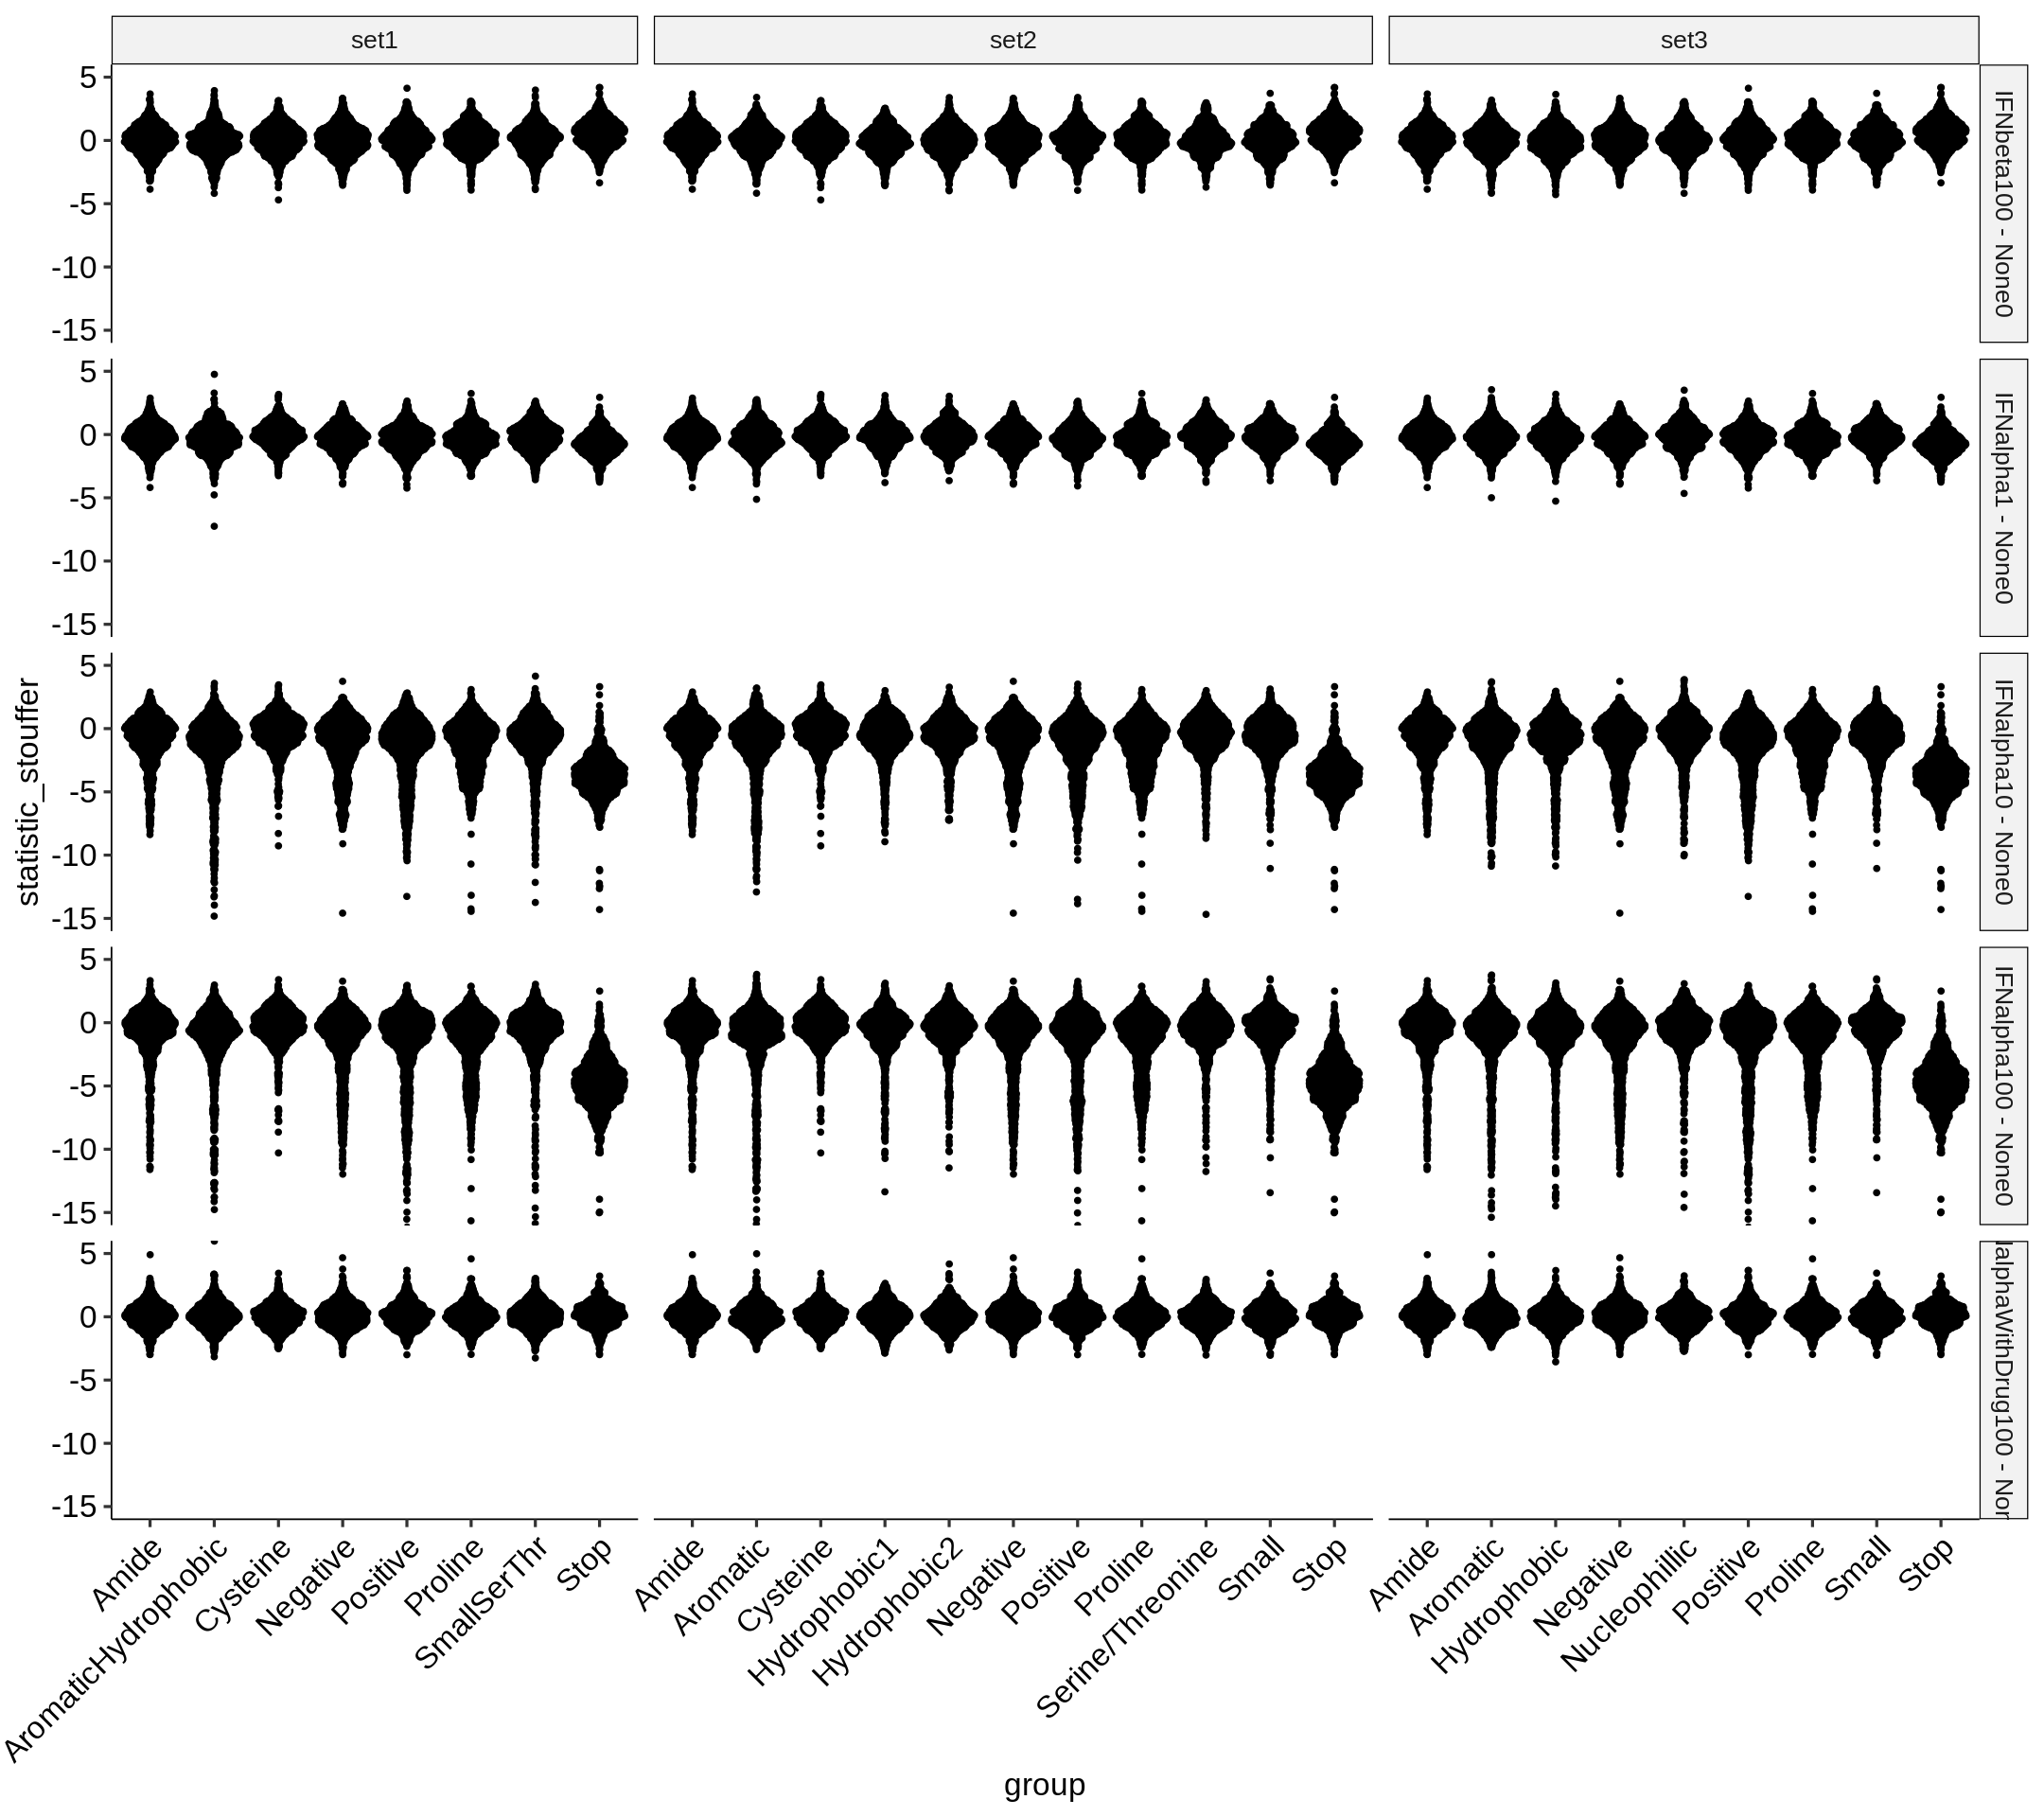

In [17]:
options(repr.plot.width = 18, repr.plot.height = 16)
agg_test %>%
    ggplot() +
        geom_quasirandom(aes(x = group, y = statistic_stouffer)) +
        facet_grid(rows = vars(condition), cols = vars(agg), space = "free", scales = "free_x") +
        theme_pubr(base_size = 20, x.text.angle = 45) +
        coord_cartesian(ylim = c(-15,5))

As always, these make a little more sense as heatmaps:

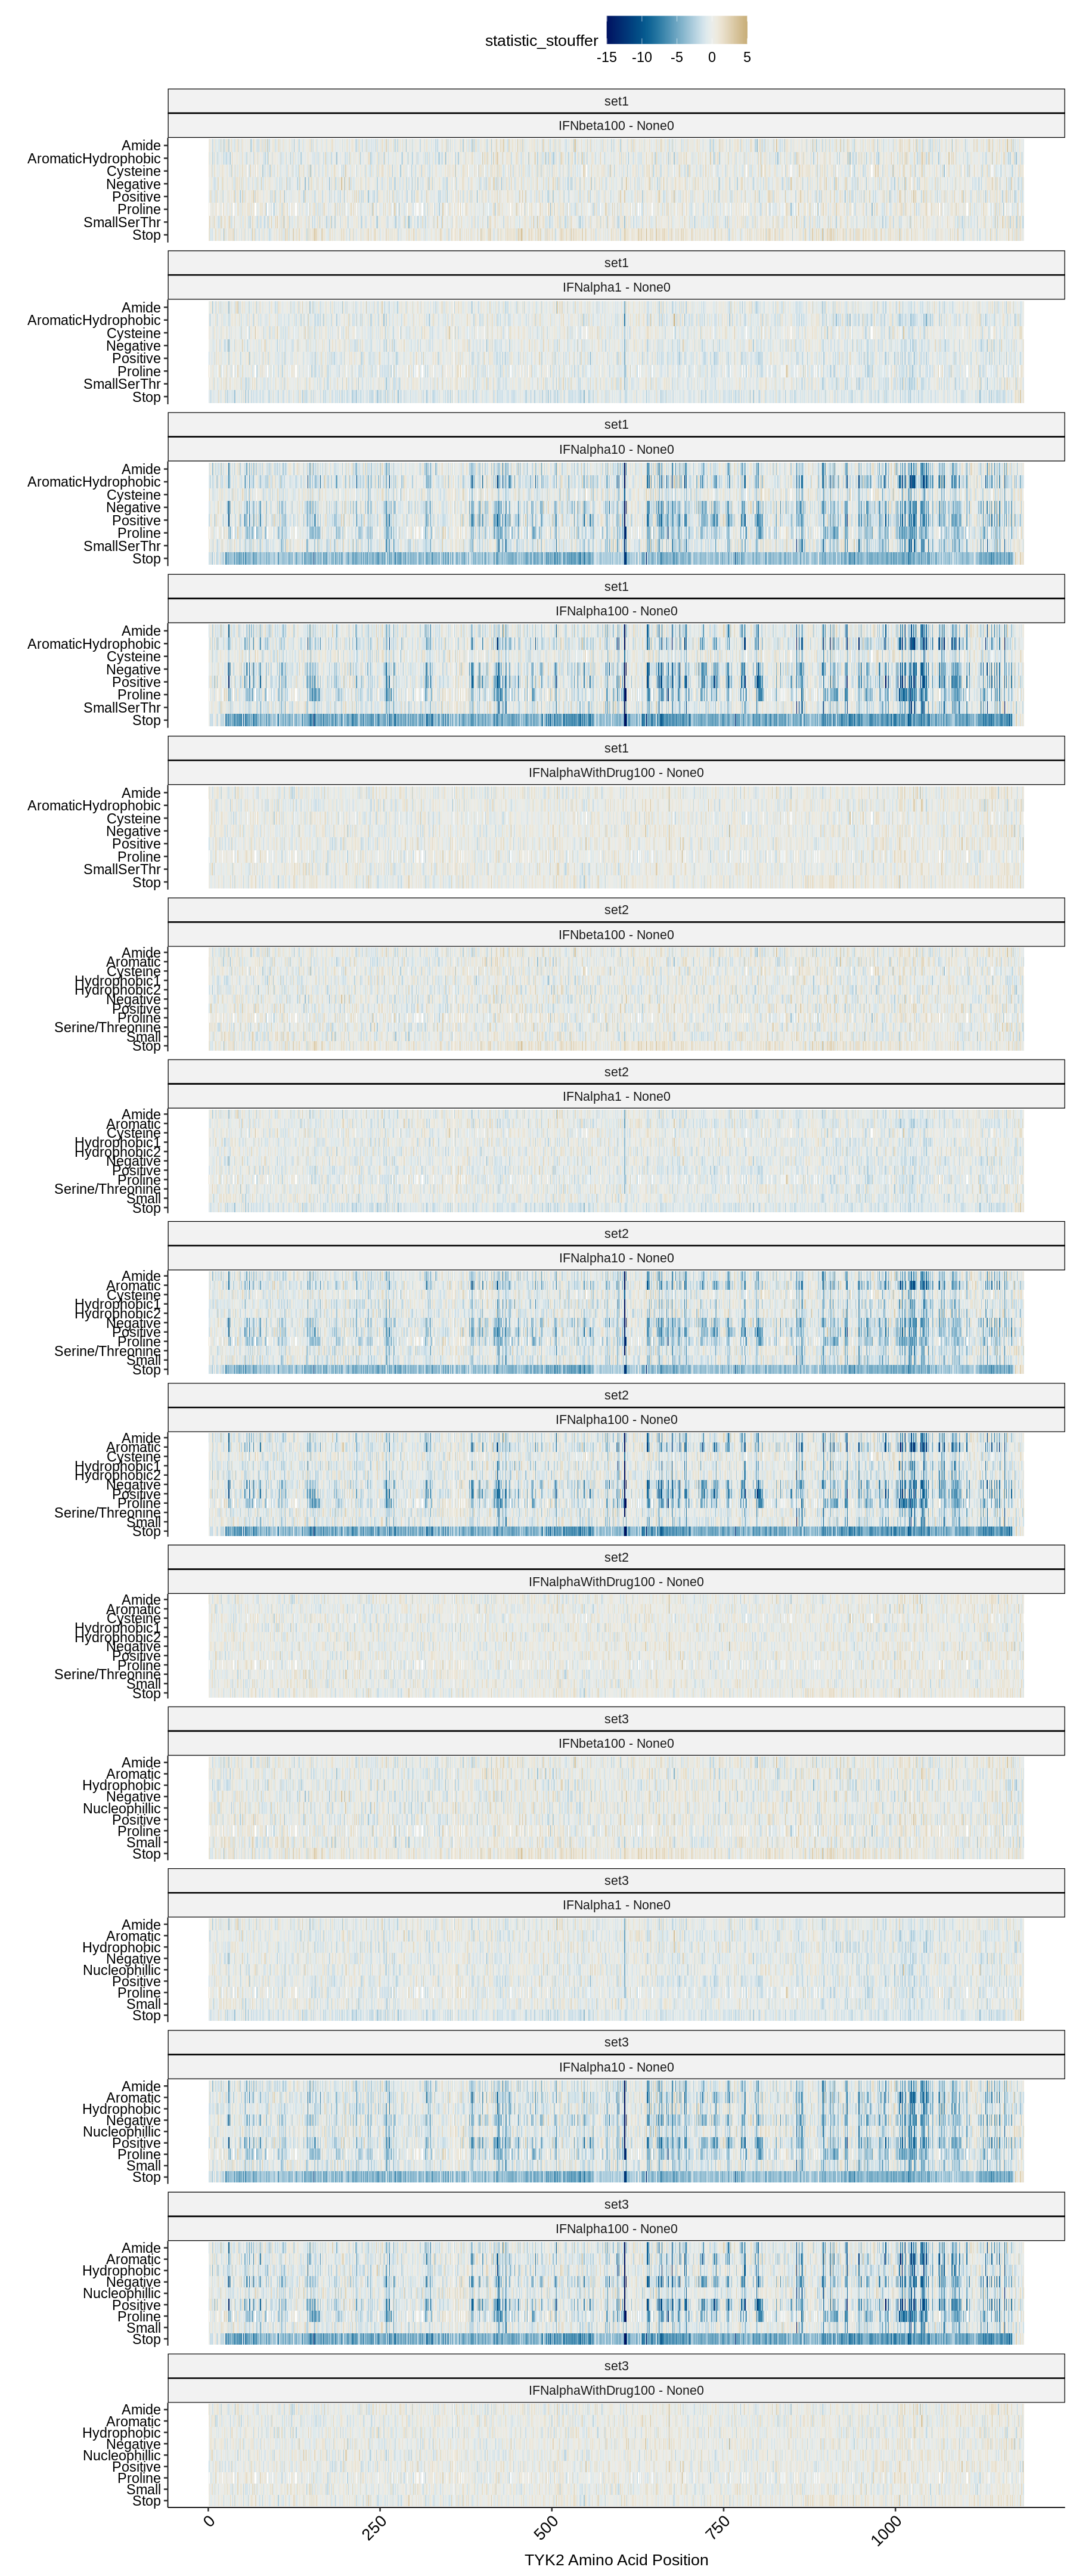

In [18]:
options(repr.plot.width = 15, repr.plot.height = 36)

agg_test %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(group), fill = statistic_stouffer)) +
            scale_fill_scico_mid(limits = c(-15,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~agg + condition, ncol = 1, scales = "free_y")

In [20]:
options(repr.plot.width = 15, repr.plot.height = 9)

set3_plot <- agg_test %>%
    filter(agg == "set3", condition %in% c("IFNalpha1 - None0",
                                           "IFNalpha10 - None0",
                                           "IFNalpha100 - None0")) %>% 
    rename("Meta-Analysis Z-Statistic" = "statistic_stouffer") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(group), fill = `Meta-Analysis Z-Statistic`)) +
            scale_fill_scico_mid(limits = c(-15,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~condition, ncol = 1, scales = "free_y")

ggsave("../dataviz/TYK2/ifna/TYK2-IFNaDMS-Assay3-BiochemAgg.pdf",
       set3_plot, width = 15, height = 9)

The main LoF effects remain what we have observed in the past (stops, prolines, etc). The main interesting GoF effects we observed in the past were in the inhibitor-treated samples, and while these positions and effects seemed very specific, we can see if there are any significant GoF effects in this analysis:

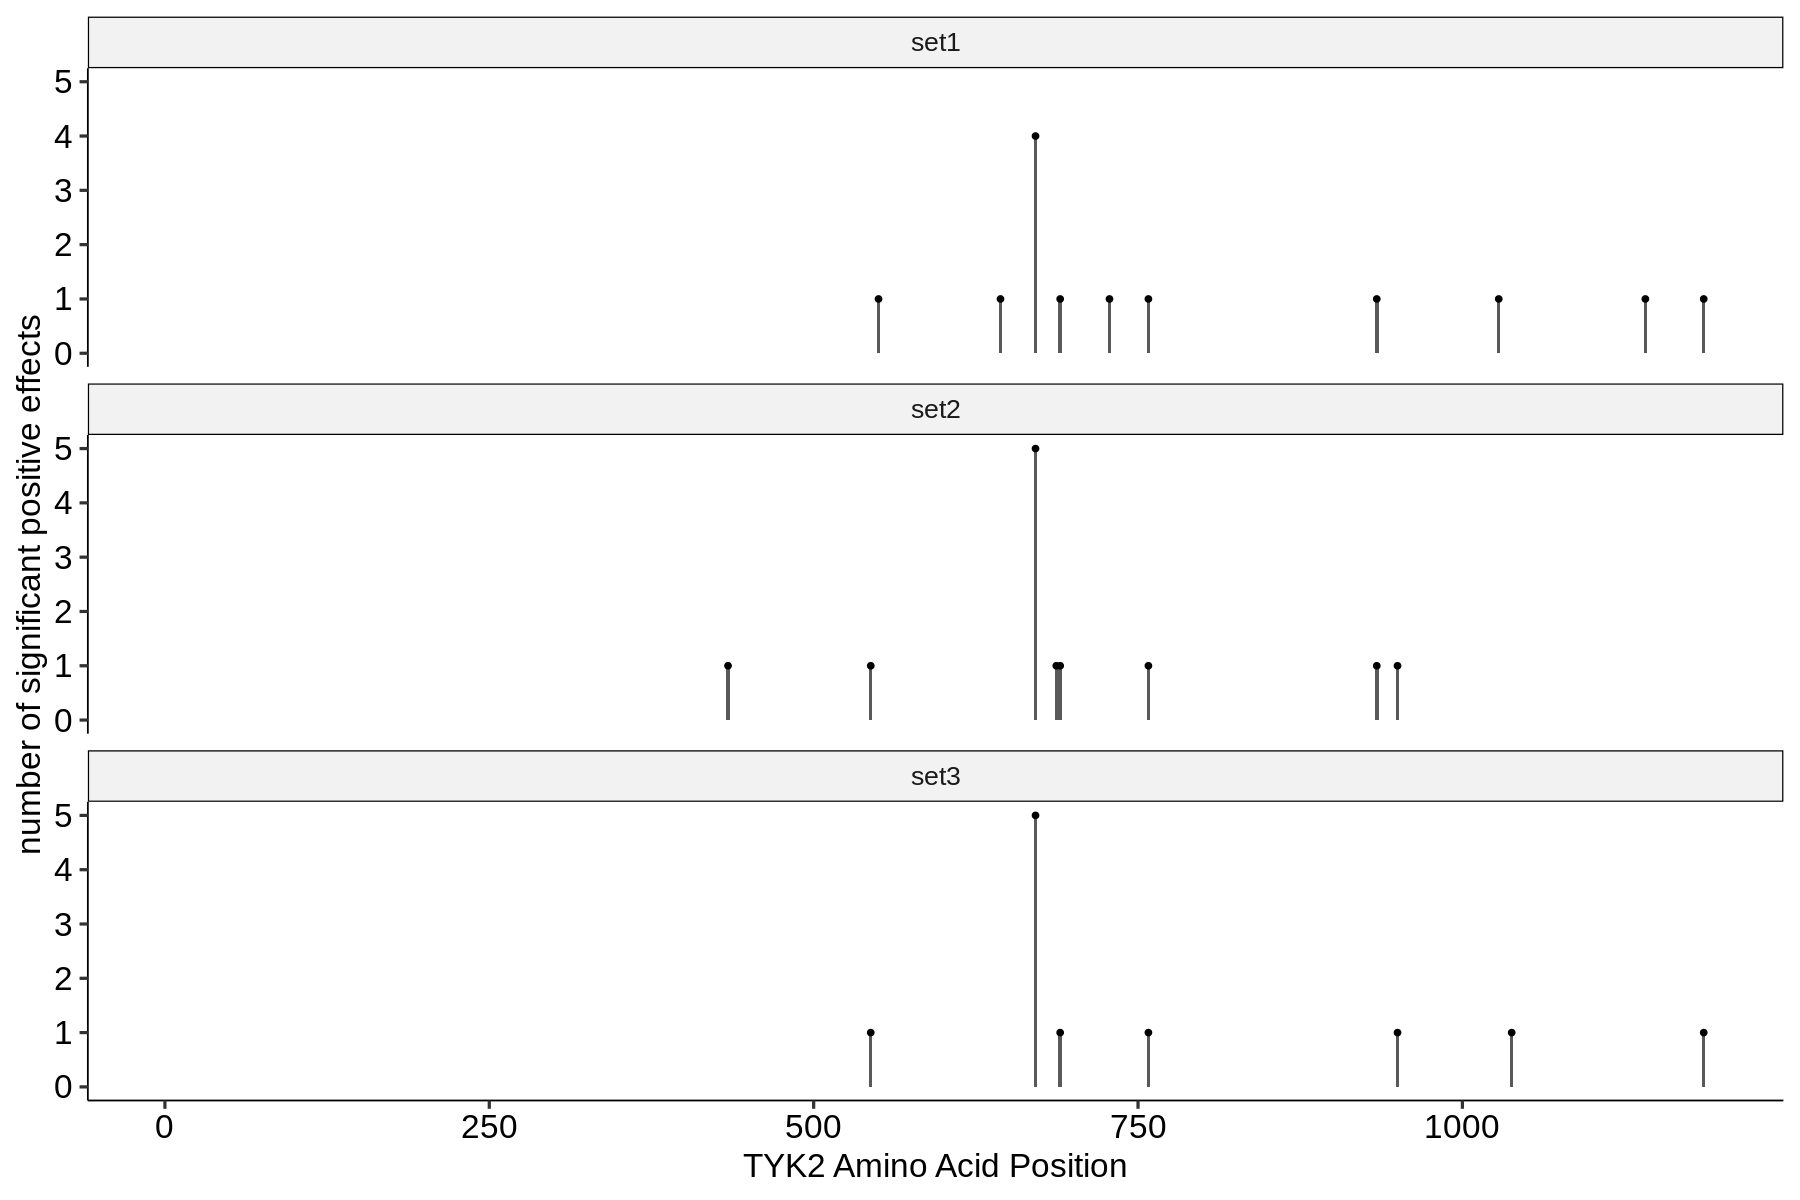

In [21]:
options(repr.plot.width = 15, repr.plot.height = 10)
agg_test %>%
    ungroup() %>%
    filter(condition == "IFNalphaWithDrug100 - None0",
           estimate > 0,
           p.adj_stouffer < 0.01) %>%
    count(agg, pos) %>%
    ggplot() +
        geom_bar(aes(x = pos, y = n), stat = "identity") +
        geom_point(aes(x = pos, y = n), stat = "identity") +
        facet_wrap(~agg, ncol = 1) +
        theme_pubr(base_size = 20) +
        ylab("number of significant positive effects") +
        xlab("TYK2 Amino Acid Position") +
        xlim(c(0,1188))

This standout position is 671, which is strongly expected given our previous observations with these data. Since this number is not too large, we can extract all significant effects in this framework and compare. The main initial takeaways are:

  - position 671: resistance induced by almost anything
  - position 690: resistance induced by proline (consistent with initial analysis)
  - position 758: resistance induced by negatively charged residues

In [22]:
agg_test %>%
    ungroup() %>%
    filter(condition == "IFNalphaWithDrug100 - None0",
           estimate > 0,
           p.adj_stouffer < 0.01) %>%
    select(agg, pos, group, condition, estimate, p.adj) %>%
    arrange(pos) %>%
    kable("markdown")



|agg  |  pos|group               |condition                   |  estimate|     p.adj|
|:----|----:|:-------------------|:---------------------------|---------:|---------:|
|set2 |  434|Hydrophobic2        |IFNalphaWithDrug100 - None0 | 0.8887010| 0.0071012|
|set2 |  544|Aromatic            |IFNalphaWithDrug100 - None0 | 0.3931423| 0.0040784|
|set3 |  544|Aromatic            |IFNalphaWithDrug100 - None0 | 0.4413305| 0.0026723|
|set1 |  550|Positive            |IFNalphaWithDrug100 - None0 | 0.4494357| 0.0095595|
|set1 |  644|AromaticHydrophobic |IFNalphaWithDrug100 - None0 | 0.4047989| 0.0035017|
|set1 |  671|Amide               |IFNalphaWithDrug100 - None0 | 0.7728190| 0.0000630|
|set1 |  671|AromaticHydrophobic |IFNalphaWithDrug100 - None0 | 0.6030824| 0.0000001|
|set1 |  671|Negative            |IFNalphaWithDrug100 - None0 | 0.7687693| 0.0001947|
|set1 |  671|Positive            |IFNalphaWithDrug100 - None0 | 0.6238538| 0.0003423|
|set2 |  671|Amide               |IFNalphaWithDrug10

#### Comparison with Midpoints <a name="part5"></a>

For chunk 10, we have the complete midpoint estimates with standard errors and Z-statistics, as well as the DMS profile across several assays. We can contrast these explicitly, since inspection (see the midpoint notebook) indicates the Z-statistics are similarly scaled across both assays, including with similar spike-in patterns.

In [3]:
compute_difference <- function(test, control, sumstats) {
    
    df1 <- sumstats %>% filter(condition == test) %>% select(-condition)
    df2 <- sumstats %>% filter(condition == control) %>% select(-condition)
    
    df <- inner_join(df1, df2,
                     by = c("pos", "chunk", "aa"))
    
    new_stats <- df %>%
        mutate(estimate = estimate.x - estimate.y,
               std.error = sqrt(std.error.x^2 + std.error.y^2),) %>%
        select(pos, chunk, aa, estimate, std.error) %>%
        ungroup()
    
    new_stats$condition = paste0(test, " - ", control)
    
    return(new_stats)
    
}

In [3]:
sumstats_midpoint <- read_tsv("../sumstats/TYK2-VAMP/midpoint/vamp-10-midpoint-sumstats.tsv")

dms <- read_tsv("../sumstats/TYK2/run3/tyk2-assay3.tsv") %>%
    filter(condition == "IFNalpha100 - None0")

dms_vamp_contrast <- bind_rows(
    dms %>%
        filter(chunk == 10 ) %>%
        select(pos, aa, estimate, p.adj) %>%
        mutate(condition = "DMS"),
    sumstats_midpoint %>%
        select(pos, mut_aa, estimate, p.adj)  %>%
        rename("aa" = "mut_aa") %>%
        mutate(condition = "VAMP")
)

Rows: 1400 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): mut_aa
dbl (8): score_mean, score_sd, pos, estimate, std.error, statistic, p.value,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 237230 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): clone, chunk, aa, version, condition
dbl (7): pos, estimate, std.error, dispersion, statistic, p.value, p.adj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


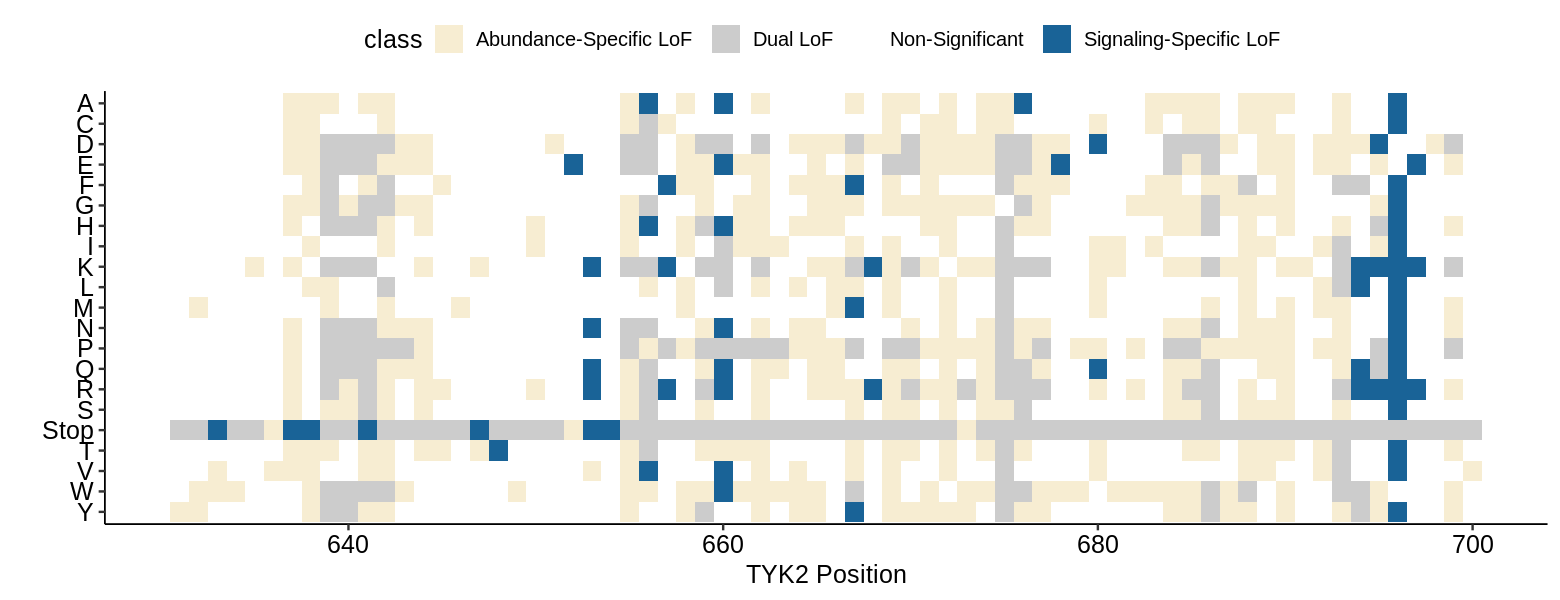

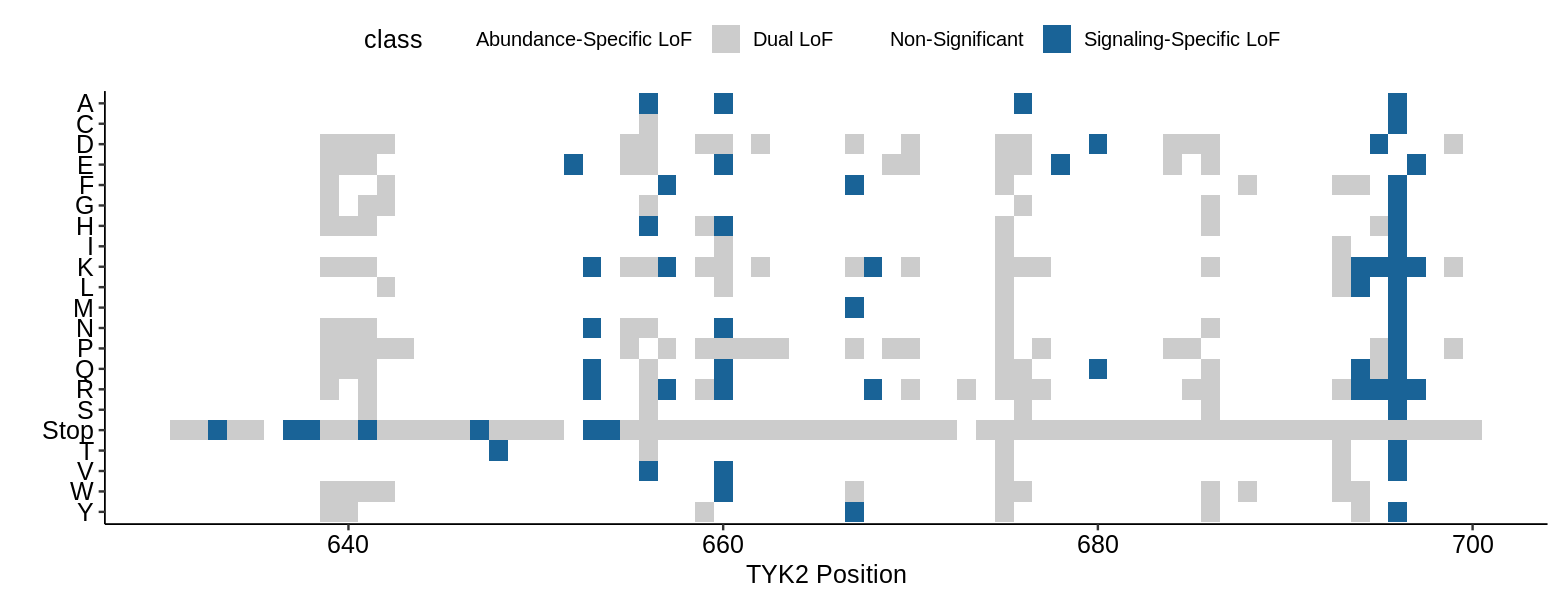

In [64]:
options(repr.plot.width = 13, repr.plot.height = 5)
dms_vamp_contrast %>% 
    mutate(sig = if_else(p.adj < 0.05 & estimate < 0, "LoF", "Non-LoF")) %>%
    select(pos, aa, condition, sig) %>%
    pivot_wider(names_from = condition, values_from = sig) %>%
    mutate(class = case_when(DMS == "LoF" & VAMP == "LoF" ~ "Dual LoF",
                             DMS == "Non-LoF" & VAMP == "LoF" ~ "Abundance-Specific LoF",
                             DMS == "LoF" & VAMP == "Non-LoF" ~ "Signaling-Specific LoF",
                             DMS == "Non-LoF" & VAMP == "Non-LoF" ~ "Non-Significant"),
           aa = if_else(aa == "*", "Stop", aa)) %>%
    ggplot() +
        geom_tile(aes(x = pos, y = fct_rev(aa), fill = class, alpha = class)) +
        theme_pubr(base_size = 15) +
        scale_fill_manual(values = c("Dual LoF" = "black",
                                      "Non-Significant" = "white",
                                      "Signaling-Specific LoF" = "#196397",
                                      "Abundance-Specific LoF" = "goldenrod")) +
        scale_alpha_manual(values = c("Dual LoF" = 0.2,
                                      "Non-Significant" = 0,
                                      "Signaling-Specific LoF" = 1,
                                      "Abundance-Specific LoF" = 0.2)) +
        ylab("") + xlab("TYK2 Position")

options(repr.plot.width = 13, repr.plot.height = 5)
dms_vamp_contrast %>% 
    mutate(sig = if_else(p.adj < 0.05 & estimate < 0, "LoF", "Non-LoF")) %>%
    select(pos, aa, condition, sig) %>%
    pivot_wider(names_from = condition, values_from = sig) %>%
    mutate(class = case_when(DMS == "LoF" & VAMP == "LoF" ~ "Dual LoF",
                             DMS == "Non-LoF" & VAMP == "LoF" ~ "Abundance-Specific LoF",
                             DMS == "LoF" & VAMP == "Non-LoF" ~ "Signaling-Specific LoF",
                             DMS == "Non-LoF" & VAMP == "Non-LoF" ~ "Non-Significant"),
           aa = if_else(aa == "*", "Stop", aa)) %>%
    ggplot() +
        geom_tile(aes(x = pos, y = fct_rev(aa), fill = class, alpha = class)) +
        theme_pubr(base_size = 15) +
        scale_fill_manual(values = c("Dual LoF" = "black",
                                      "Non-Significant" = "white",
                                      "Signaling-Specific LoF" = "#196397",
                                      "Abundance-Specific LoF" = "white")) +
        scale_alpha_manual(values = c("Dual LoF" = 0.2,
                                      "Non-Significant" = 0,
                                      "Signaling-Specific LoF" = 1,
                                      "Abundance-Specific LoF" = 0.2)) +
        ylab("") + xlab("TYK2 Position")

In [11]:
dms_vamp_contrast_z <- inner_join(
    dms %>%
        filter(chunk == 10 ) %>%
        select(pos, aa, estimate, p.adj),
    sumstats_midpoint %>%
        select(pos, mut_aa, estimate, p.adj)  %>%
        rename("aa" = "mut_aa"), by = c("pos", "aa"))  %>%
    mutate(group = case_when(p.adj.x < 0.05 & p.adj.y < 0.05 ~ "Both",
                             p.adj.x < 0.05 & p.adj.y > 0.05 ~ "IFNa Only",
                             p.adj.x > 0.05 & p.adj.y < 0.05 ~ "Abundance Only",
                             TRUE ~ "Neither"))

In [12]:
compare_scatter <- dms_vamp_contrast_z %>%
    ggplot(aes(x = estimate.x, y = estimate.y, color = group)) +
        geom_point(size = 2) +
        theme_pubr(base_size = 20, x.text.angle = 45) +
        scale_color_manual(values = c("Both" = "black", "Neither" = "gray",
                                      "IFNa Only" = "red", "Abundance Only" = "purple")) +
        theme(legend.title = element_blank()) + 
        guides(colour = guide_legend(override.aes = list(size=7))) +
        geom_hline(yintercept = 0) + geom_vline(xintercept = 0) +
        xlab("TYK2 DMS Log2 Fold Change") +
        ylab("TYK2 VAMP-seq Midpoint Shift")
    

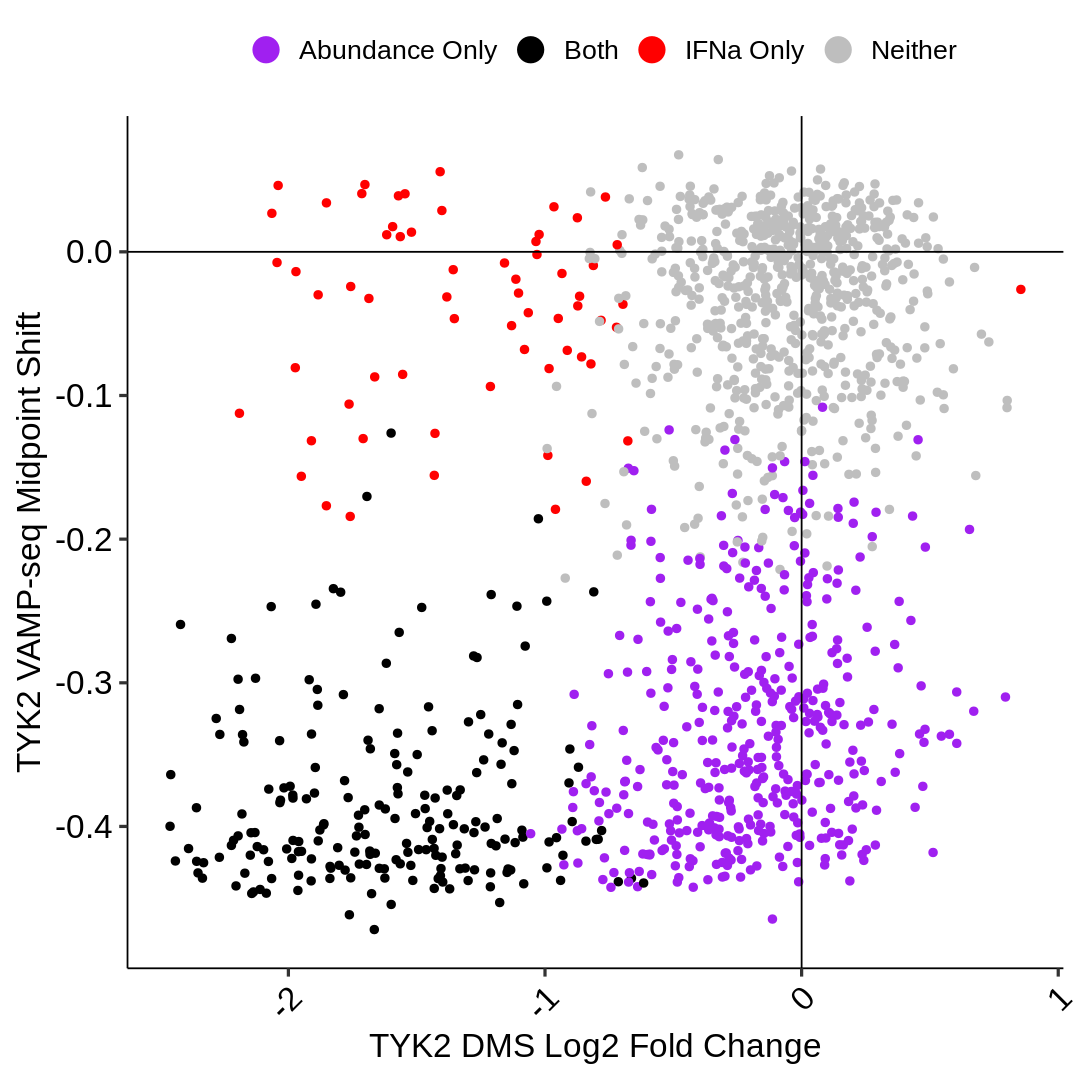

In [14]:
options(repr.plot.width = 9, repr.plot.height = 9)
compare_scatter